# Clustering analysis on 10k PBMC data

In [1]:
from keras.utils.vis_utils import model_to_dot
from keras.utils import normalize, to_categorical
from IPython.display import SVG

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scanpy as sc
import os

from imp import load_source
from models import *

Using TensorFlow backend.


In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
from tensorflow.python.util import deprecation
deprecation._PRINT_DEPRECATION_WARNINGS = False

## Adversarial Autoencoder: Basic Architecture

<img src="img/adversarial_autoencoder_model.png" width="800px" style="float:center" >

### Build the model

In [4]:
# Network parameters

LATENT_DIM = 10
LAYERS_ENC_DIM = [200, 100, 50, 50, 40, 30, 20, LATENT_DIM]
LAYERS_DEC_DIM = [LATENT_DIM, 20, 30, 40, 50, 50, 100, 200]
LAYERS_DIS_DIM = [LATENT_DIM, 20, 30, 40, 50, 50, 100, 200]

BATCH_SIZE = 35
EPOCHS = 100

In [5]:
model = AAE1(latent_dim=LATENT_DIM,
             layers_enc_dim=LAYERS_ENC_DIM,
             layers_dec_dim=LAYERS_DEC_DIM,
             layers_dis_dim=LAYERS_DIS_DIM,
             batch_size=BATCH_SIZE,
             epochs=EPOCHS)

In [6]:
# Import dataset

data_path = '../data/proc/pbmc10k.h5ad'

model.load_data(data_path)

Dataset imported.


In [7]:
# Rescale gene expression data

model.rescale_data()

Gene expression data rescaled.


In [8]:
# Show network hyper-parameters

print("List of Network parameters")
model.get_parameters()

List of Network parameters


Value                               Description
batch_size                      35                                batch size
epochs                         100                          number of epochs
alpha                          0.1       alpha coeff. in activation function
do_rate                        0.1                              dropout rate
kernel_initializer  glorot_uniform    kernel initializer of all dense layers
bias_initializer             zeros      bias initializer of all dense layers
l2_weight                     0.01        weight of l2 kernel regularization
l1_weight                     0.01      weight of l1 activity regularization
latent_dim                      10               dimension of latent space Z
layer_1_enc_dim                200        dimension of encoder dense layer 1
layer_2_enc_dim                100        dimension of encoder dense layer 2
layer_3_enc_dim                 50        dimension of encoder dense layer 3
layer_4_enc_dim                 50        dimension of encoder dense layer 4
layer_5_enc_dim                 40        dimension of encoder dense layer 5
layer_6_enc_dim                 30        dimension of encoder dense layer 6
layer_7_enc_dim                 20        dimension of encoder dense layer 7
layer_8_enc_dim                 10        dimension of encoder dense layer 8
layer_1_dec_dim                 10        dimension of decoder dense layer 1
layer_2_dec_dim                 20        dimension of decoder dense layer 2
layer_3_dec_dim                 30        dimension of decoder dense layer 3
layer_4_dec_dim                 40        dimension of decoder dense layer 4
layer_5_dec_dim                 50        dimension of decoder dense layer 5
layer_6_dec_dim                 50        dimension of decoder dense layer 6
layer_7_dec_dim                100        dimension of decoder dense layer 7
layer_8_dec_dim                200        dimension of decoder dense layer 8
lr_ae                       0.0002              learning rate of autoencoder
dr_ae                        1e-06                 decay rate of autoencoder
layer_1_dis_dim                 10  dimension of discriminator dense layer 1
layer_2_dis_dim                 20  dimension of discriminator dense layer 2
layer_3_dis_dim                 30  dimension of discriminator dense layer 3
layer_4_dis_dim                 40  dimension of discriminator dense layer 4
layer_5_dis_dim                 50  dimension of discriminator dense layer 5
layer_6_dis_dim                 50  dimension of discriminator dense layer 6
layer_7_dis_dim                100  dimension of discriminator dense layer 7
layer_8_dis_dim                200  dimension of discriminator dense layer 8
lr_dis                      0.0001            learning rate of discriminator
dr_dis                       1e-06               decay rate of discriminator
lr_gen                      0.0001                learning rate of generator
dr_gen                       1e-06                   decay rate of generator

In [9]:
# Build the full model

model.build_model()

In [10]:
# Model summary

model.get_summary()


Encoder Network
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
X (InputLayer)                  (None, 1789)         0                                            
__________________________________________________________________________________________________
D_O (Dropout)                   (None, 1789)         0           X[0][0]                          
__________________________________________________________________________________________________
H_1 (Dense)                     (None, 200)          357800      D_O[0][0]                        
__________________________________________________________________________________________________
BN_1 (BatchNormalization)       (None, 200)          800         H_1[0][0]                        
____________________________________________________________________________________________

Total params: 425,321
Trainable params: 390,520
Non-trainable params: 34,801
_________________________________________________________________

Discriminator Network
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Z (InputLayer)               (None, 10)                0         
_________________________________________________________________
D_O (Dropout)                (None, 10)                0         
_________________________________________________________________
H_1 (Dense)                  (None, 10)                100       
_________________________________________________________________
BN_1 (BatchNormalization)    (None, 10)                40        
_________________________________________________________________
LR_1 (LeakyReLU)             (None, 10)                0         
_________________________________________________________________
D_1 (Dropout)                (None, 10)   

In [11]:
# Export model graphs

os.makedirs('../graphs/AAE1/PBMC10k', exist_ok=True)
model.export_graph('../graphs/AAE1/PBMC10k')

Model graphs saved.



### Visualize graphs


ENCODER


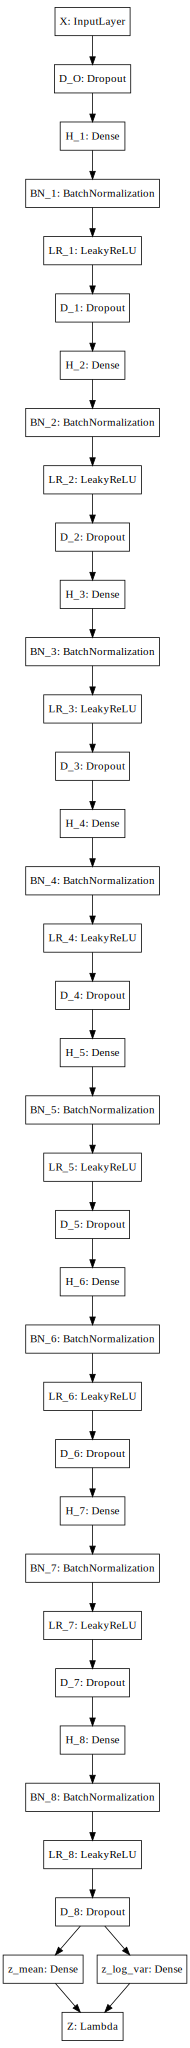

In [12]:
print("\nENCODER")
print("=======")
SVG(model_to_dot(model.encoder).create(prog='dot', format='svg'))


DECODER


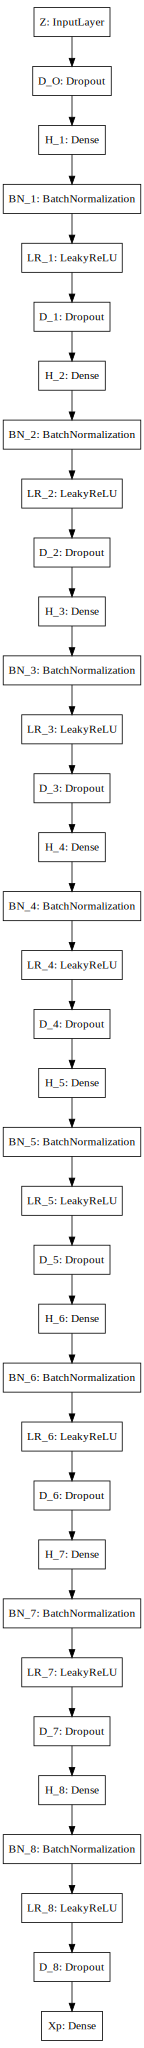

In [13]:
print("\nDECODER")
print("=======")
SVG(model_to_dot(model.decoder).create(prog='dot', format='svg'))


AUTOENCODER


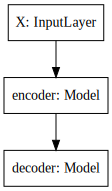

In [14]:
print("\nAUTOENCODER")
print("===========")
SVG(model_to_dot(model.autoencoder).create(prog='dot', format='svg'))


GENERATOR


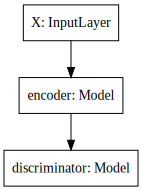

In [15]:
print("\nGENERATOR")
print("=========")
SVG(model_to_dot(model.generator).create(prog='dot', format='svg'))


DISCRIMINATOR


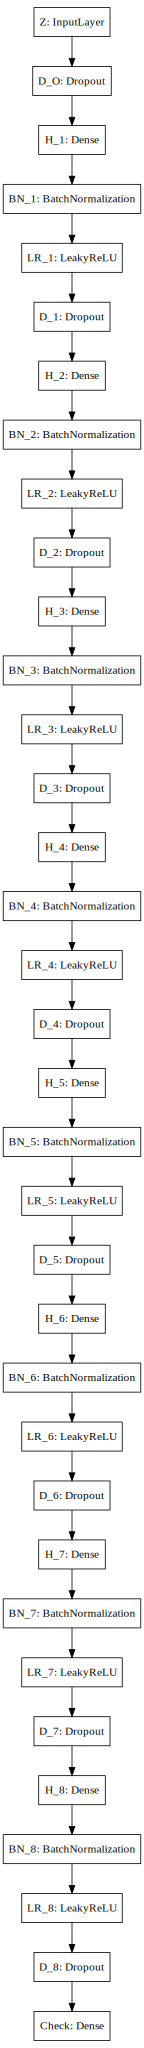

In [16]:
print("\nDISCRIMINATOR")
print("=============")
SVG(model_to_dot(model.discriminator).create(prog='dot', format='svg'))

### Train the model

Epoch 100/100, reconstruction loss: 0.973156, generation loss: 0.692987, discriminator loss: 0.693386


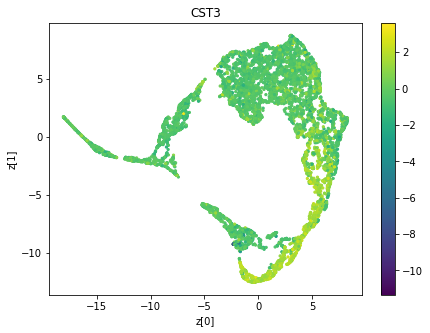

Training completed.


In [12]:
# graph=True to show the data points in the 2-D latent space

GENE = 'CST3' # used only for training visualization 

rec_loss, gen_loss, dis_loss = model.train(graph=True, gene=GENE)

In [16]:
# save models in h5 format
os.makedirs('../models/AAE1/PBMC10k', exist_ok=True)
model.export_model('../models/AAE1/PBMC10k')

All networks exported in h5 format.


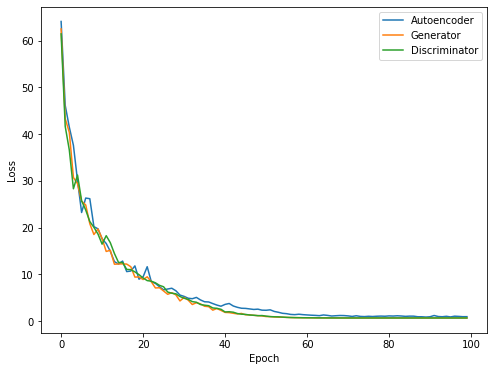

In [17]:
# Plot training & validation loss values

plt.figure(figsize=(8, 6))
axes = plt.gca()
plt.plot(rec_loss)
plt.plot(gen_loss)
plt.plot(dis_loss)
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Autoencoder', 'Generator', 'Discriminator'], loc='upper right')
plt.show()

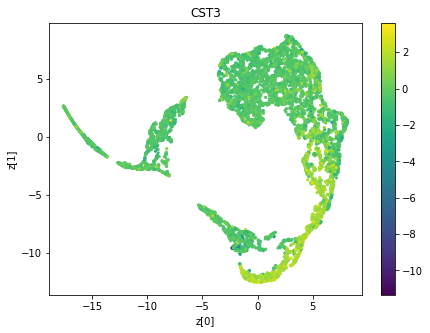

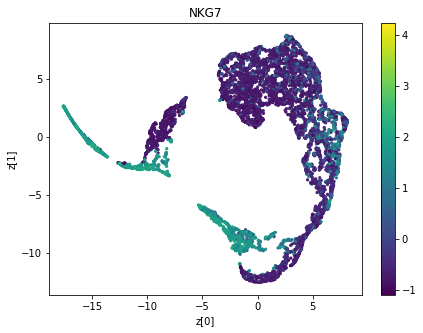

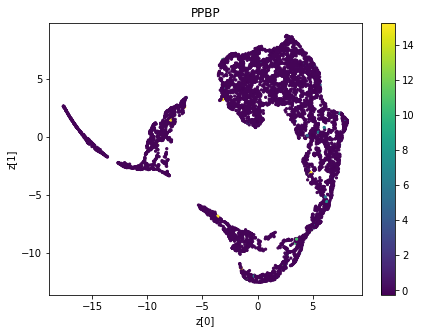

In [18]:
GENE_LIST = ['CST3', 'NKG7', 'PPBP']
model.plot_umap(gene_selected=GENE_LIST, louvain=False)

## Incorporating Label Information in the Adversarial Regularization

### Build the model

In [6]:
# Network parameters

LATENT_DIM = 10
LAYERS_ENC_DIM = [200, 100, 50, 50, 40, 30, 20, LATENT_DIM]
LAYERS_DEC_DIM = [LATENT_DIM, 20, 30, 40, 50, 50, 100, 200]
LAYERS_DIS_DIM = [LATENT_DIM, 20, 30, 40, 50, 50, 100, 200]

BATCH_SIZE = 35
EPOCHS = 100

In [7]:
model = AAE2(latent_dim=LATENT_DIM,
             layers_enc_dim=LAYERS_ENC_DIM, 
             layers_dec_dim=LAYERS_DEC_DIM, 
             layers_dis_dim=LAYERS_DIS_DIM,
             batch_size=BATCH_SIZE,
             epochs=EPOCHS)

In [8]:
# Import dataset

data_path = '../data/proc/pbmc10k.h5ad'

model.load_data(data_path)

Dataset imported.


In [9]:
# Rescale gene expression data

model.rescale_data()

Gene expression data rescaled.


In [10]:
# Show network hyper-parameters

print("List of Network parameters")
model.get_parameters()

List of Network parameters


Value                               Description
batch_size                      35                                batch size
epochs                         100                          number of epochs
alpha                          0.1       alpha coeff. in activation function
do_rate                        0.1                              dropout rate
kernel_initializer  glorot_uniform    kernel initializer of all dense layers
bias_initializer             zeros      bias initializer of all dense layers
l2_weight                     0.01        weight of l2 kernel regularization
l1_weight                     0.01      weight of l1 activity regularization
latent_dim                      10               dimension of latent space Z
layer_1_enc_dim                200        dimension of encoder dense layer 1
layer_2_enc_dim                100        dimension of encoder dense layer 2
layer_3_enc_dim                 50        dimension of encoder dense layer 3
layer_4_enc_dim                 50        dimension of encoder dense layer 4
layer_5_enc_dim                 40        dimension of encoder dense layer 5
layer_6_enc_dim                 30        dimension of encoder dense layer 6
layer_7_enc_dim                 20        dimension of encoder dense layer 7
layer_8_enc_dim                 10        dimension of encoder dense layer 8
layer_1_dec_dim                 10        dimension of decoder dense layer 1
layer_2_dec_dim                 20        dimension of decoder dense layer 2
layer_3_dec_dim                 30        dimension of decoder dense layer 3
layer_4_dec_dim                 40        dimension of decoder dense layer 4
layer_5_dec_dim                 50        dimension of decoder dense layer 5
layer_6_dec_dim                 50        dimension of decoder dense layer 6
layer_7_dec_dim                100        dimension of decoder dense layer 7
layer_8_dec_dim                200        dimension of decoder dense layer 8
lr_ae                       0.0002              learning rate of autoencoder
dr_ae                        1e-06                 decay rate of autoencoder
layer_1_dis_dim                 10  dimension of discriminator dense layer 1
layer_2_dis_dim                 20  dimension of discriminator dense layer 2
layer_3_dis_dim                 30  dimension of discriminator dense layer 3
layer_4_dis_dim                 40  dimension of discriminator dense layer 4
layer_5_dis_dim                 50  dimension of discriminator dense layer 5
layer_6_dis_dim                 50  dimension of discriminator dense layer 6
layer_7_dis_dim                100  dimension of discriminator dense layer 7
layer_8_dis_dim                200  dimension of discriminator dense layer 8
lr_dis                      0.0001            learning rate of discriminator
dr_dis                       1e-06               decay rate of discriminator
lr_gen                      0.0001                learning rate of generator
dr_gen                       1e-06                   decay rate of generator

In [11]:
# Build the full model

model.build_model()

In [12]:
# Model summary

model.get_summary()


Encoder Network
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
X (InputLayer)                  (None, 1789)         0                                            
__________________________________________________________________________________________________
D_O (Dropout)                   (None, 1789)         0           X[0][0]                          
__________________________________________________________________________________________________
H_1 (Dense)                     (None, 200)          357800      D_O[0][0]                        
__________________________________________________________________________________________________
BN_1 (BatchNormalization)       (None, 200)          800         H_1[0][0]                        
____________________________________________________________________________________________

Layer (type)                 Output Shape              Param #   
X (InputLayer)               (None, 1789)              0         
_________________________________________________________________
encoder (Model)              [(None, 10), (None, 10),  391520    
_________________________________________________________________
decoder (Model)              (None, 1789)              393189    
Total params: 784,709
Trainable params: 782,709
Non-trainable params: 2,000
_________________________________________________________________

Generator Network
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
X (InputLayer)                  (None, 1789)         0                                            
__________________________________________________________________________________________________
encoder (Model)                 [(None, 10), (N

Total params: 33,941
Trainable params: 32,941
Non-trainable params: 1,000
__________________________________________________________________________________________________


In [13]:
# Export model graphs

os.makedirs('../graphs/AAE2/PBMC10k', exist_ok=True)
model.export_graph('../graphs/AAE2/PBMC10k')

Model graphs saved.



### Visualize graphs


ENCODER


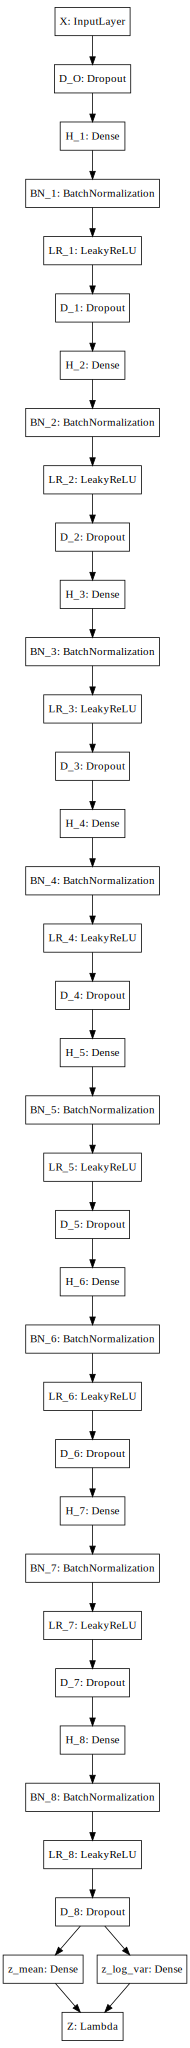

In [12]:
print("\nENCODER")
print("=======")
SVG(model_to_dot(model.encoder).create(prog='dot', format='svg'))


DECODER


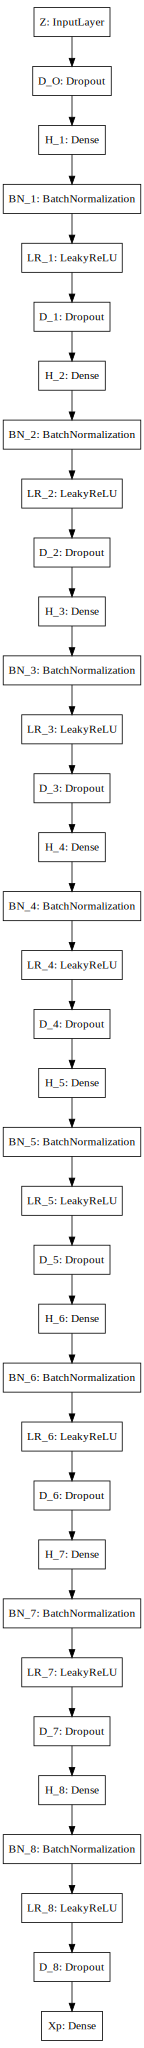

In [13]:
print("\nDECODER")
print("=======")
SVG(model_to_dot(model.decoder).create(prog='dot', format='svg'))


AUTOENCODER


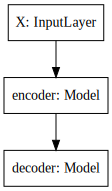

In [14]:
print("\nAUTOENCODER")
print("===========")
SVG(model_to_dot(model.autoencoder).create(prog='dot', format='svg'))


GENERATOR


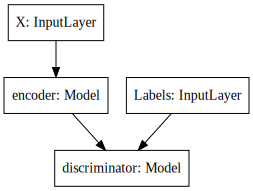

In [15]:
print("\nGENERATOR")
print("=========")
SVG(model_to_dot(model.generator).create(prog='dot', format='svg'))


DISCRIMINATOR


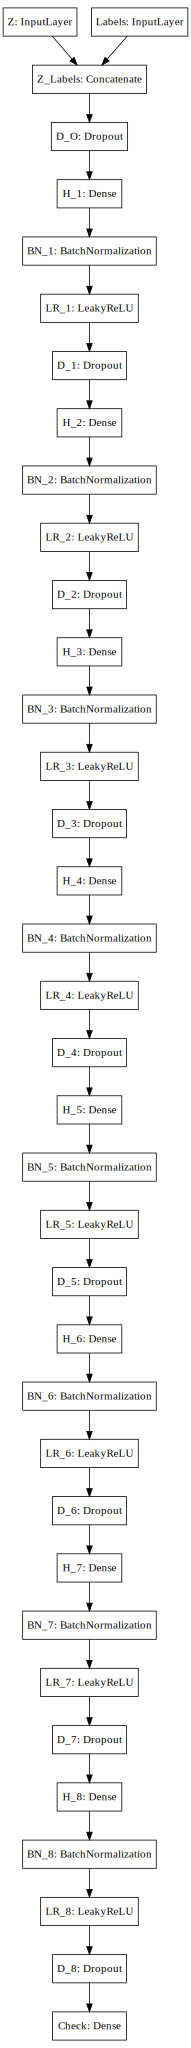

In [16]:
print("\nDISCRIMINATOR")
print("=============")
SVG(model_to_dot(model.discriminator).create(prog='dot', format='svg'))

### Train the model

Epoch 100/100, reconstruction loss: 1.054700, generation loss: 0.693680, discriminator loss: 0.693373


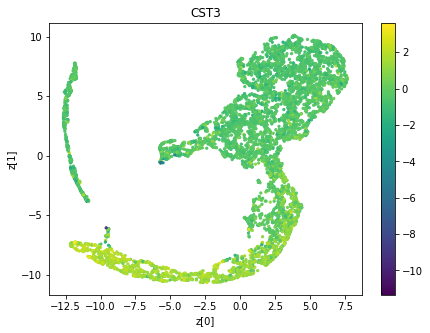

Training completed.


In [14]:
# graph=True to show the data points in the 2-D latent space

GENE = 'CST3' # used only for training visualization 

rec_loss, gen_loss, dis_loss = model.train(graph=True, gene=GENE)

In [15]:
# save models in h5 format
os.makedirs('../models/AAE2/PBMC10k', exist_ok=True)
model.export_model('../models/AAE2/PBMC10k')

All networks exported in h5 format.


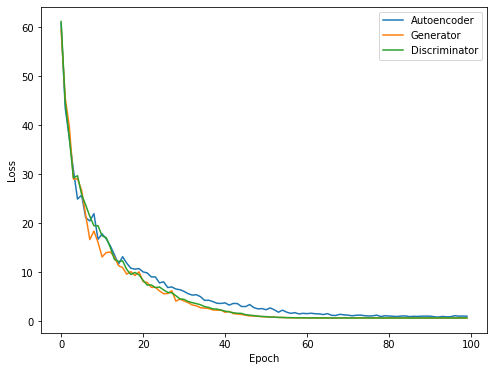

In [16]:
# Plot training & validation loss values

plt.figure(figsize=(8, 6))
axes = plt.gca()
plt.plot(rec_loss)
plt.plot(gen_loss)
plt.plot(dis_loss)
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Autoencoder', 'Generator', 'Discriminator'], loc='upper right')
plt.show()

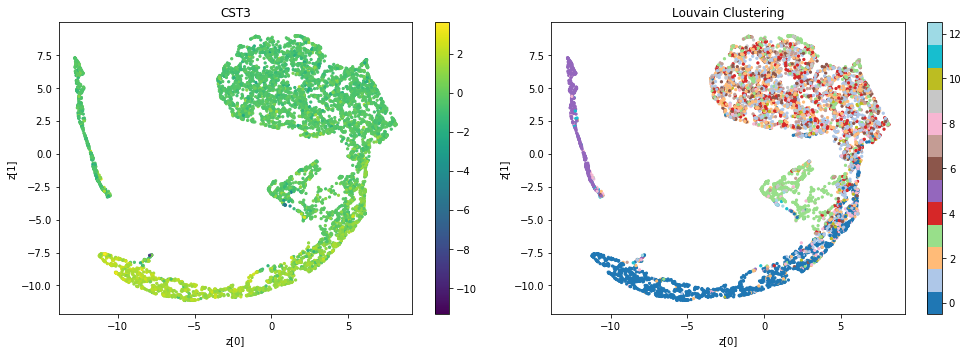

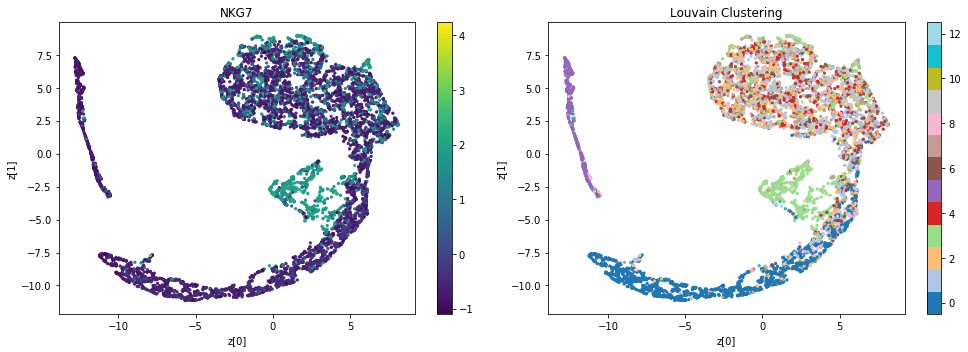

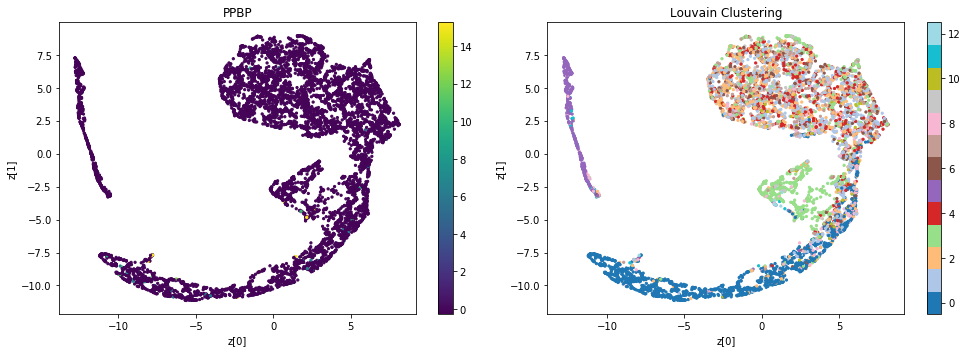

In [17]:
GENE_LIST = ['CST3', 'NKG7', 'PPBP']
model.plot_umap(gene_selected=GENE_LIST, louvain=True)

## Supervised Adversarial Autoencoder

### Build the model

In [4]:
# Network parameters

LATENT_DIM = 10
LAYERS_ENC_DIM = [200, 100, 50, 50, 40, 30, 20, LATENT_DIM]
LAYERS_DEC_DIM = [LATENT_DIM, 20, 30, 40, 50, 50, 100, 200]
LAYERS_DIS_DIM = [LATENT_DIM, 20, 30, 40, 50, 50, 100, 200]

BATCH_SIZE = 35
EPOCHS = 100

In [5]:
model = AAE3(latent_dim=LATENT_DIM,
             layers_enc_dim=LAYERS_ENC_DIM, 
             layers_dec_dim=LAYERS_DEC_DIM, 
             layers_dis_dim=LAYERS_DIS_DIM,
             batch_size=BATCH_SIZE,
             epochs=EPOCHS)

In [6]:
# Import dataset

data_path = '../data/proc/pbmc10k.h5ad'

model.load_data(data_path)

Dataset imported.


In [7]:
# Rescale gene expression data

model.rescale_data()

Gene expression data rescaled.


In [8]:
# Show network hyper-parameters

print("List of Network parameters")
model.get_parameters()

List of Network parameters


Value                               Description
batch_size                      35                                batch size
epochs                         100                          number of epochs
alpha                          0.1       alpha coeff. in activation function
do_rate                        0.1                              dropout rate
kernel_initializer  glorot_uniform    kernel initializer of all dense layers
bias_initializer             zeros      bias initializer of all dense layers
l2_weight                     0.01        weight of l2 kernel regularization
l1_weight                     0.01      weight of l1 activity regularization
latent_dim                      10               dimension of latent space Z
layer_1_enc_dim                200        dimension of encoder dense layer 1
layer_2_enc_dim                100        dimension of encoder dense layer 2
layer_3_enc_dim                 50        dimension of encoder dense layer 3
layer_4_enc_dim                 50        dimension of encoder dense layer 4
layer_5_enc_dim                 40        dimension of encoder dense layer 5
layer_6_enc_dim                 30        dimension of encoder dense layer 6
layer_7_enc_dim                 20        dimension of encoder dense layer 7
layer_8_enc_dim                 10        dimension of encoder dense layer 8
layer_1_dec_dim                 10        dimension of decoder dense layer 1
layer_2_dec_dim                 20        dimension of decoder dense layer 2
layer_3_dec_dim                 30        dimension of decoder dense layer 3
layer_4_dec_dim                 40        dimension of decoder dense layer 4
layer_5_dec_dim                 50        dimension of decoder dense layer 5
layer_6_dec_dim                 50        dimension of decoder dense layer 6
layer_7_dec_dim                100        dimension of decoder dense layer 7
layer_8_dec_dim                200        dimension of decoder dense layer 8
lr_ae                       0.0002              learning rate of autoencoder
dr_ae                        1e-06                 decay rate of autoencoder
layer_1_dis_dim                 10  dimension of discriminator dense layer 1
layer_2_dis_dim                 20  dimension of discriminator dense layer 2
layer_3_dis_dim                 30  dimension of discriminator dense layer 3
layer_4_dis_dim                 40  dimension of discriminator dense layer 4
layer_5_dis_dim                 50  dimension of discriminator dense layer 5
layer_6_dis_dim                 50  dimension of discriminator dense layer 6
layer_7_dis_dim                100  dimension of discriminator dense layer 7
layer_8_dis_dim                200  dimension of discriminator dense layer 8
lr_dis                      0.0001            learning rate of discriminator
dr_dis                       1e-06               decay rate of discriminator
lr_gen                      0.0001                learning rate of generator
dr_gen                       1e-06                   decay rate of generator

In [9]:
# Build the full model

model.build_model()

In [10]:
# Model summary

model.get_summary()


Encoder Network
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
X (InputLayer)                  (None, 1789)         0                                            
__________________________________________________________________________________________________
D_O (Dropout)                   (None, 1789)         0           X[0][0]                          
__________________________________________________________________________________________________
H_1 (Dense)                     (None, 200)          357800      D_O[0][0]                        
__________________________________________________________________________________________________
BN_1 (BatchNormalization)       (None, 200)          800         H_1[0][0]                        
____________________________________________________________________________________________

__________________________________________________________________________________________________
Labels (InputLayer)             (None, 13)           0                                            
__________________________________________________________________________________________________
Z_Labels (Concatenate)          (None, 23)           0           Z[0][0]                          
                                                                 Labels[0][0]                     
__________________________________________________________________________________________________
D_O (Dropout)                   (None, 23)           0           Z_Labels[0][0]                   
__________________________________________________________________________________________________
H_1 (Dense)                     (None, 10)           230         D_O[0][0]                        
__________________________________________________________________________________________________
BN_1 (Batc

BN_2 (BatchNormalization)    (None, 20)                80        
_________________________________________________________________
LR_2 (LeakyReLU)             (None, 20)                0         
_________________________________________________________________
D_2 (Dropout)                (None, 20)                0         
_________________________________________________________________
H_3 (Dense)                  (None, 30)                600       
_________________________________________________________________
BN_3 (BatchNormalization)    (None, 30)                120       
_________________________________________________________________
LR_3 (LeakyReLU)             (None, 30)                0         
_________________________________________________________________
D_3 (Dropout)                (None, 30)                0         
_________________________________________________________________
H_4 (Dense)                  (None, 40)                1200      
__________

In [11]:
# Export model graphs

os.makedirs('../graphs/AAE3/PBMC10k', exist_ok=True)
model.export_graph('../graphs/AAE3/PBMC10k')

Model graphs saved.



### Visualize graphs


ENCODER


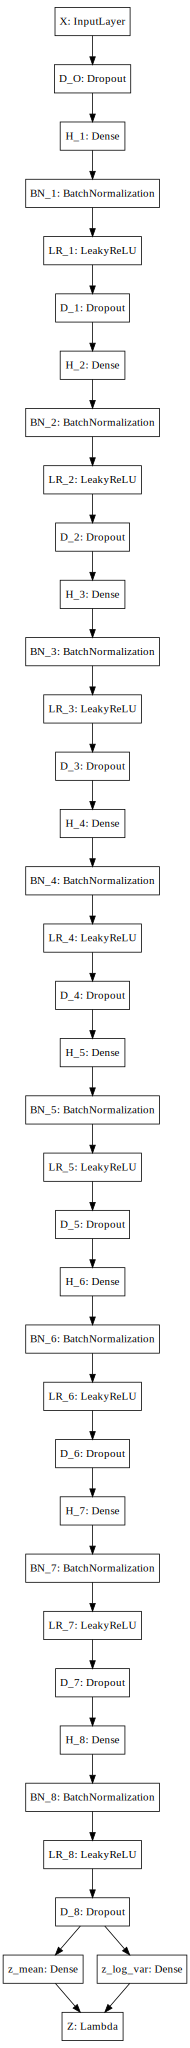

In [12]:
print("\nENCODER")
print("=======")
SVG(model_to_dot(model.encoder).create(prog='dot', format='svg'))


DECODER


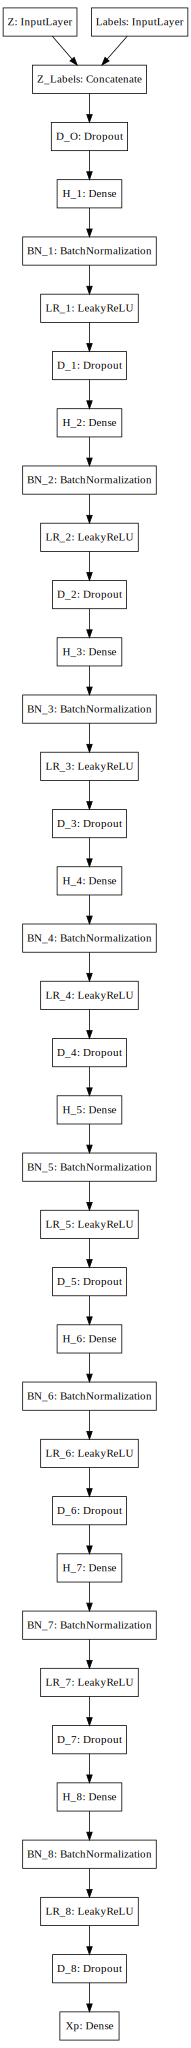

In [13]:
print("\nDECODER")
print("=======")
SVG(model_to_dot(model.decoder).create(prog='dot', format='svg'))


AUTOENCODER


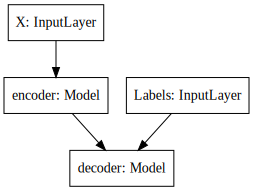

In [14]:
print("\nAUTOENCODER")
print("===========")
SVG(model_to_dot(model.autoencoder).create(prog='dot', format='svg'))


GENERATOR


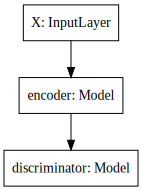

In [15]:
print("\nGENERATOR")
print("=========")
SVG(model_to_dot(model.generator).create(prog='dot', format='svg'))


DISCRIMINATOR


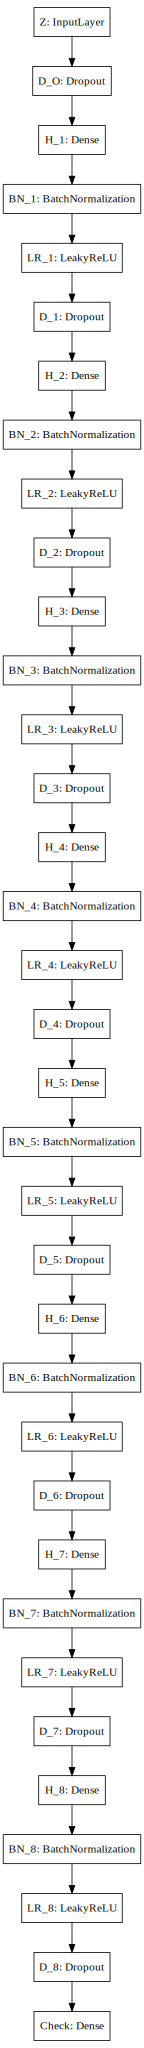

In [16]:
print("\nDISCRIMINATOR")
print("=============")
SVG(model_to_dot(model.discriminator).create(prog='dot', format='svg'))

### Train the model

Epoch 100/100, reconstruction loss: 0.936930, generation loss: 0.694314, discriminator loss: 0.693295


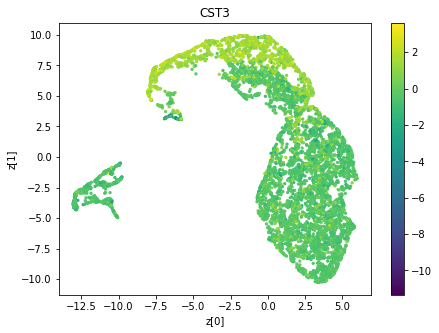

Training completed.


In [12]:
# graph=True to show the data points in the 2-D latent space

GENE = 'CST3' # used only for training visualization 

rec_loss, gen_loss, dis_loss = model.train(graph=True, gene=GENE)

In [13]:
# save models in h5 format
os.makedirs('../models/AAE3/PBMC10k', exist_ok=True)
model.export_model('../models/AAE3/PBMC10k')

All networks exported in h5 format.


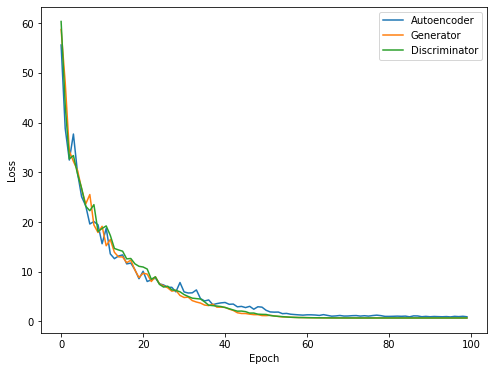

In [14]:
# Plot training & validation loss values

plt.figure(figsize=(8, 6))
axes = plt.gca()
plt.plot(rec_loss)
plt.plot(gen_loss)
plt.plot(dis_loss)
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Autoencoder', 'Generator', 'Discriminator'], loc='upper right')
plt.show()

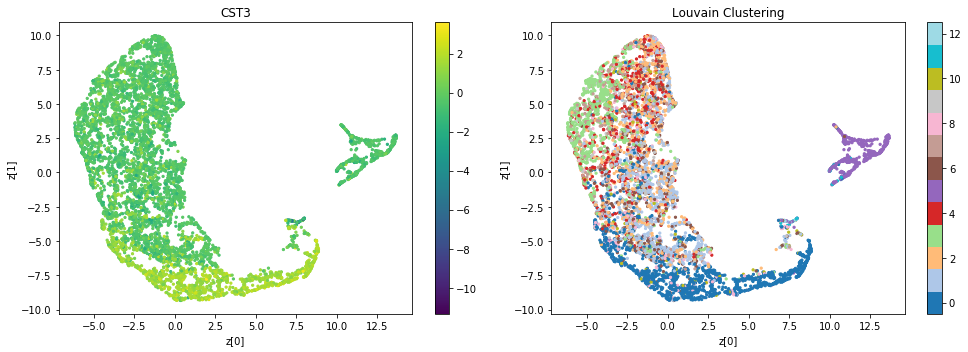

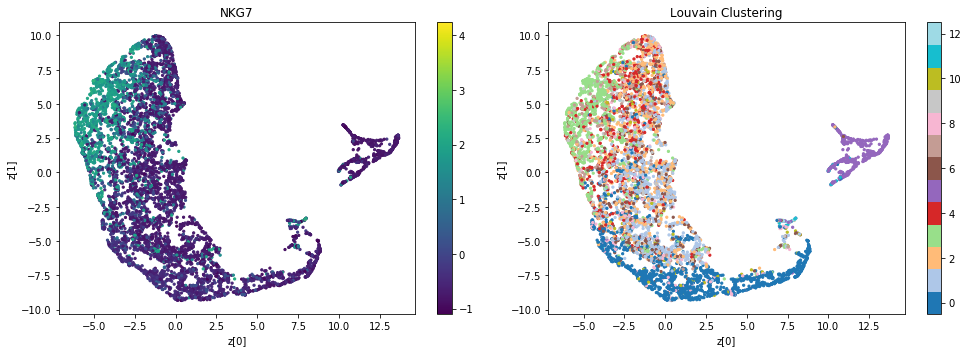

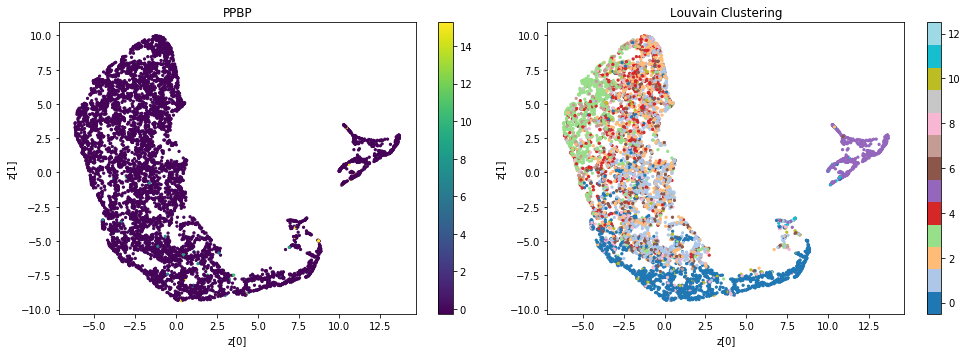

In [15]:
GENE_LIST = ['CST3', 'NKG7', 'PPBP']
model.plot_umap(gene_selected=GENE_LIST, louvain=True)

## Semi-supervised Adversarial Autoencoder

### Build the model

In [4]:
# Network parameters

LATENT_DIM = 10
LAYERS_ENC_DIM = [200, 100, 50, 50, 40, 40, 30, 30, 20, LATENT_DIM]
LAYERS_DEC_DIM = [25, 25, 30, 30, 40, 40, 50, 50, 100, 200]
LAYERS_DIS_DIM = [LATENT_DIM, 20, 30, 30, 40, 40, 50, 50, 100, 200]
LAYERS_DIS_CAT_DIM = [20, 20, 30, 30, 40, 40, 50, 50, 100]

BATCH_SIZE = 35
EPOCHS = 100
TEMPERATURE = 0.05

In [5]:
model = AAE4(latent_dim=LATENT_DIM,
             layers_enc_dim=LAYERS_ENC_DIM,
             layers_dec_dim=LAYERS_DEC_DIM,
             layers_dis_dim=LAYERS_DIS_DIM,
             layers_dis_cat_dim=LAYERS_DIS_CAT_DIM,
             batch_size=BATCH_SIZE,
             epochs=EPOCHS,
             tau=TEMPERATURE)

In [6]:
# Import dataset

data_path = '../data/proc/pbmc10k.h5ad'

model.load_data(data_path)

Dataset imported.


In [7]:
# Rescale gene expression data

model.rescale_data()

Gene expression data rescaled.


In [8]:
# Show network hyper-parameters

print("List of Network parameters")
model.get_parameters()

List of Network parameters


Value  \
batch_size                       35   
epochs                          100   
alpha                           0.1   
do_rate                         0.1   
kernel_initializer   glorot_uniform   
bias_initializer              zeros   
l2_weight                      0.01   
l1_weight                      0.01   
latent_dim                       10   
layer_1_enc_dim                 200   
layer_2_enc_dim                 100   
layer_3_enc_dim                  50   
layer_4_enc_dim                  50   
layer_5_enc_dim                  40   
layer_6_enc_dim                  40   
layer_7_enc_dim                  30   
layer_8_enc_dim                  30   
layer_9_enc_dim                  20   
layer_10_enc_dim                 10   
layer_1_dec_dim                  25   
layer_2_dec_dim                  25   
layer_3_dec_dim                  30   
layer_4_dec_dim                  30   
layer_5_dec_dim                  40   
layer_6_dec_dim                  40   
layer_7_dec_dim                  50   
layer_8_dec_dim                  50   
layer_9_dec_dim                 100   
layer_10_dec_dim                200   
lr_ae                        0.0002   
dr_ae                         1e-06   
layer_1_dis_dim                  10   
layer_2_dis_dim                  20   
layer_3_dis_dim                  30   
layer_4_dis_dim                  30   
layer_5_dis_dim                  40   
layer_6_dis_dim                  40   
layer_7_dis_dim                  50   
layer_8_dis_dim                  50   
layer_9_dis_dim                 100   
layer_10_dis_dim                200   
lr_dis                       0.0001   
dr_dis                        1e-06   
lr_gen                       0.0001   
dr_gen                        1e-06   
layer_1_dis_cat_dim            20.0   
layer_2_dis_cat_dim            20.0   
layer_3_dis_cat_dim            30.0   
layer_4_dis_cat_dim            30.0   
layer_5_dis_cat_dim            40.0   
layer_6_dis_cat_dim            40.0   
layer_7_dis_cat_dim            50.0   
layer_8_dis_cat_dim            50.0   
layer_9_dis_cat_dim           100.0   
lr_dis_cat                   0.0001   
dr_dis_cat                    1e-06   
tau                            0.05   

                                                       Description  
batch_size                                              batch size  
epochs                                            number of epochs  
alpha                          alpha coeff. in activation function  
do_rate                                               dropout rate  
kernel_initializer          kernel initializer of all dense layers  
bias_initializer              bias initializer of all dense layers  
l2_weight                       weight of l2 kernel regularization  
l1_weight                     weight of l1 activity regularization  
latent_dim                             dimension of latent space Z  
layer_1_enc_dim                 dimension of encoder dense layer 1  
layer_2_enc_dim                 dimension of encoder dense layer 2  
layer_3_enc_dim                 dimension of encoder dense layer 3  
layer_4_enc_dim                 dimension of encoder dense layer 4  
layer_5_enc_dim                 dimension of encoder dense layer 5  
layer_6_enc_dim                 dimension of encoder dense layer 6  
layer_7_enc_dim                 dimension of encoder dense layer 7  
layer_8_enc_dim                 dimension of encoder dense layer 8  
layer_9_enc_dim                 dimension of encoder dense layer 9  
layer_10_enc_dim               dimension of encoder dense layer 10  
layer_1_dec_dim                 dimension of decoder dense layer 1  
layer_2_dec_dim                 dimension of decoder dense layer 2  
layer_3_dec_dim                 dimension of decoder dense layer 3  
layer_4_dec_dim                 dimension of decoder dense layer 4  
layer_5_dec_dim                 dimension of decoder dense layer 5  
layer_6_dec_dim                 dimension 

In [9]:
# Build the full model

model.build_model()

In [10]:
# Model summary

model.get_summary()


Encoder Network
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
X (InputLayer)                  (None, 1789)         0                                            
__________________________________________________________________________________________________
D_O (Dropout)                   (None, 1789)         0           X[0][0]                          
__________________________________________________________________________________________________
H_1 (Dense)                     (None, 200)          357800      D_O[0][0]                        
__________________________________________________________________________________________________
BN_1 (BatchNormalization)       (None, 200)          800         H_1[0][0]                        
____________________________________________________________________________________________

y (InputLayer)                  (None, 13)           0                                            
__________________________________________________________________________________________________
Z_y (Concatenate)               (None, 23)           0           Z[0][0]                          
                                                                 y[0][0]                          
__________________________________________________________________________________________________
D_O (Dropout)                   (None, 23)           0           Z_y[0][0]                        
__________________________________________________________________________________________________
H_1 (Dense)                     (None, 25)           575         D_O[0][0]                        
__________________________________________________________________________________________________
BN_1 (BatchNormalization)       (None, 25)           100         H_1[0][0]                        
__________

__________________________________________________________________________________________________
D_10 (Dropout)                  (None, 200)          0           LR_10[0][0]                      
__________________________________________________________________________________________________
Xp (Dense)                      (None, 1789)         359589      D_10[0][0]                       
Total params: 397,099
Trainable params: 395,919
Non-trainable params: 1,180
__________________________________________________________________________________________________

Autoencoder Network
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
X (InputLayer)                  (None, 1789)         0                                            
__________________________________________________________________________________________________
encoder (Mod

Total params: 36,581
Trainable params: 35,441
Non-trainable params: 1,140
_________________________________________________________________

Categorical Discriminator Network
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
y (InputLayer)               (None, 13)                0         
_________________________________________________________________
D_O (Dropout)                (None, 13)                0         
_________________________________________________________________
H_1 (Dense)                  (None, 20)                260       
_________________________________________________________________
BN_1 (BatchNormalization)    (None, 20)                80        
_________________________________________________________________
LR_1 (LeakyReLU)             (None, 20)                0         
_________________________________________________________________
D_1 (Dropout)                (Non

In [11]:
# Export model graphs

os.makedirs('../graphs/AAE4/PBMC10k', exist_ok=True)
model.export_graph('../graphs/AAE4/PBMC10k')

Model graphs saved.



### Visualize graphs


ENCODER


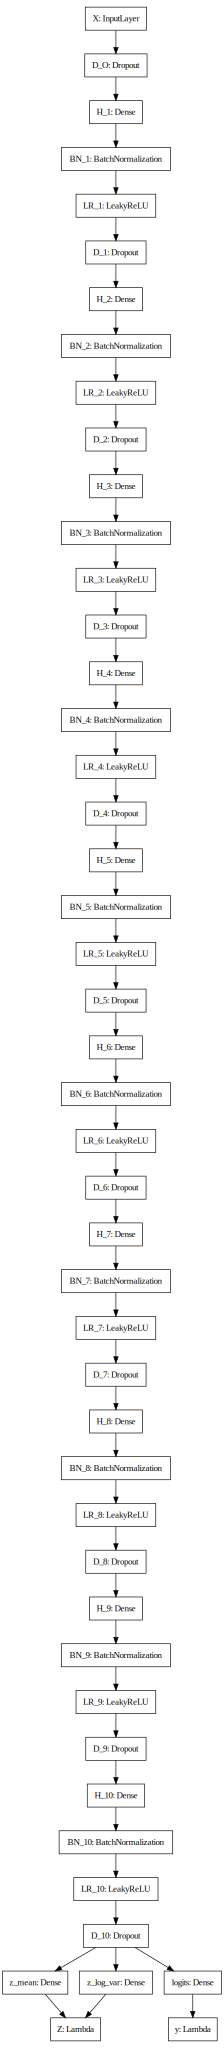

In [12]:
print("\nENCODER")
print("=======")
SVG(model_to_dot(model.encoder).create(prog='dot', format='svg'))


DECODER


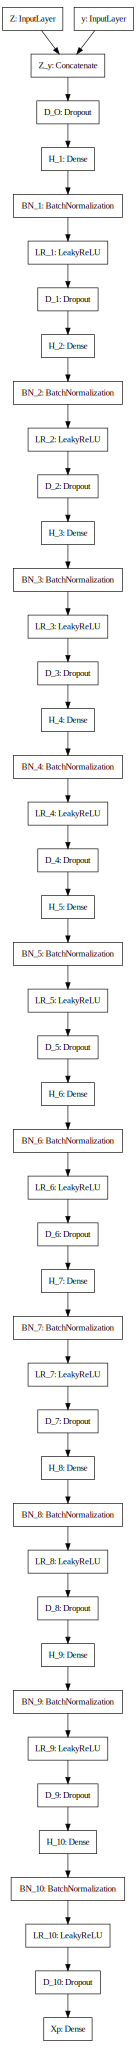

In [13]:
print("\nDECODER")
print("=======")
SVG(model_to_dot(model.decoder).create(prog='dot', format='svg'))


AUTOENCODER


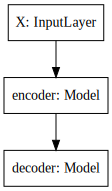

In [14]:
print("\nAUTOENCODER")
print("===========")
SVG(model_to_dot(model.autoencoder).create(prog='dot', format='svg'))


GENERATOR


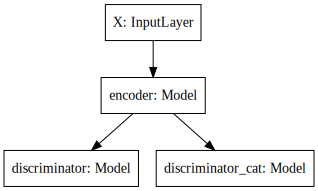

In [15]:
print("\nGENERATOR")
print("=========")
SVG(model_to_dot(model.generator).create(prog='dot', format='svg'))


DISCRIMINATOR


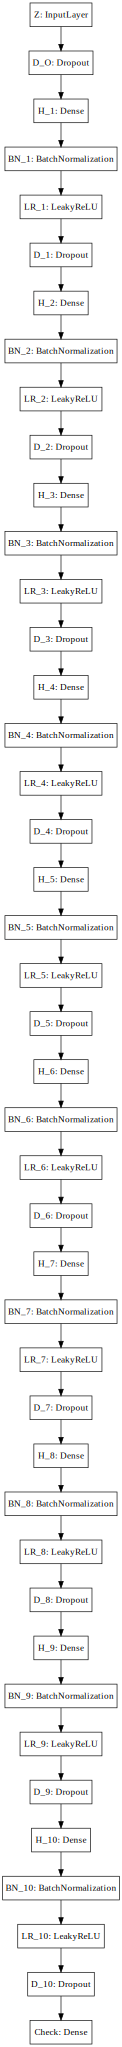

In [16]:
print("\nDISCRIMINATOR")
print("=============")
SVG(model_to_dot(model.discriminator).create(prog='dot', format='svg'))


CATEGORICAL DISCRIMINATOR


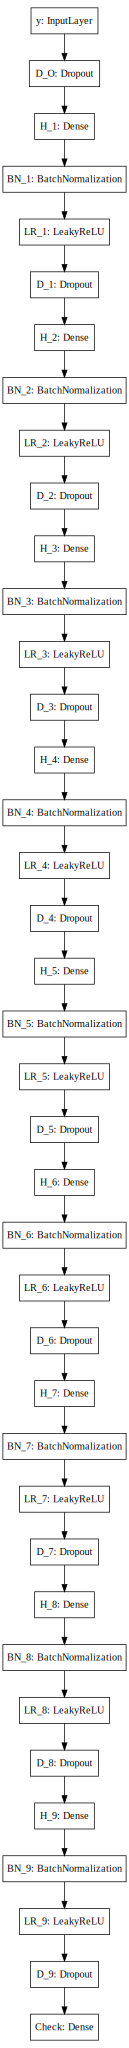

In [17]:
print("\nCATEGORICAL DISCRIMINATOR")
print("=========================")
SVG(model_to_dot(model.discriminator_cat).create(prog='dot', format='svg'))

### Train the model

Epoch 100/100, reconstruction loss: 1.182287, generation loss: 1.386365, discriminator loss: 0.693240, cat. discriminator loss: 0.693153


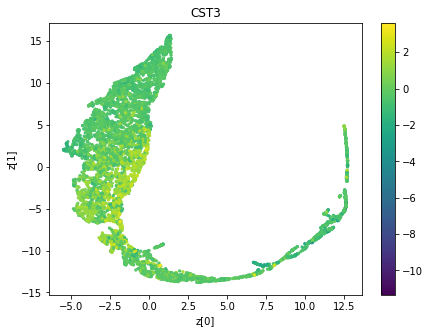

Training completed.


In [18]:
# graph=True to show the data points in the 2-D latent space

GENE = 'CST3' # used only for training visualization 

rec_loss, gen_loss, dis_loss, dis_cat_loss = model.train(graph=True, gene=GENE)

In [19]:
# save models in h5 format
os.makedirs('../models/AAE4/PBMC10k', exist_ok=True)
model.export_model('../models/AAE4/PBMC10k')

All networks exported in h5 format.


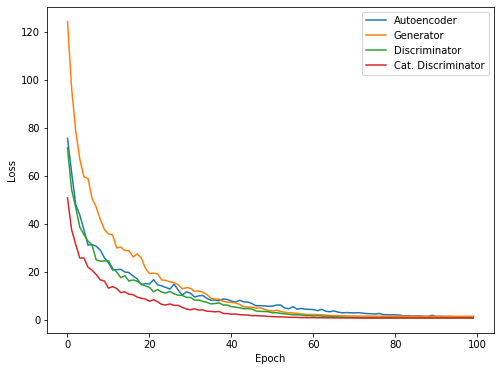

In [20]:
# Plot training loss values

plt.figure(figsize=(8, 6))
axes = plt.gca()
plt.plot(rec_loss)
plt.plot(gen_loss)
plt.plot(dis_loss)
plt.plot(dis_cat_loss)
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Autoencoder', 'Generator', 'Discriminator', 'Cat. Discriminator'], 
           loc='upper right')
plt.show()

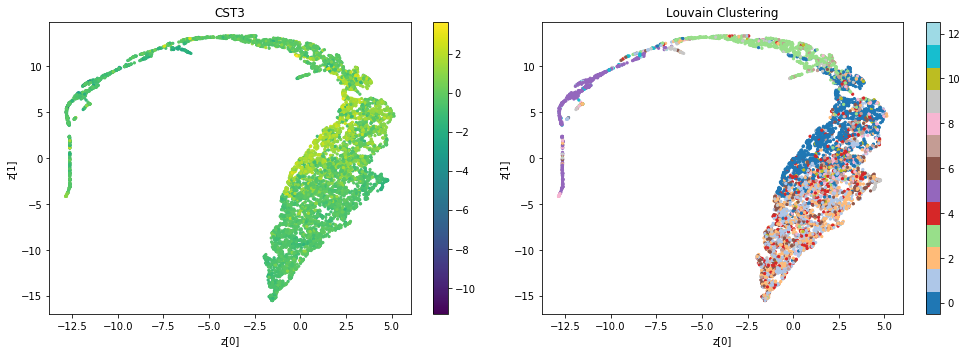

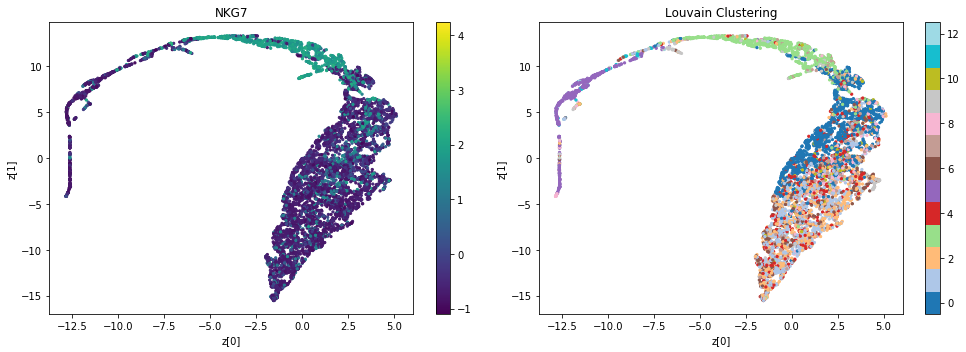

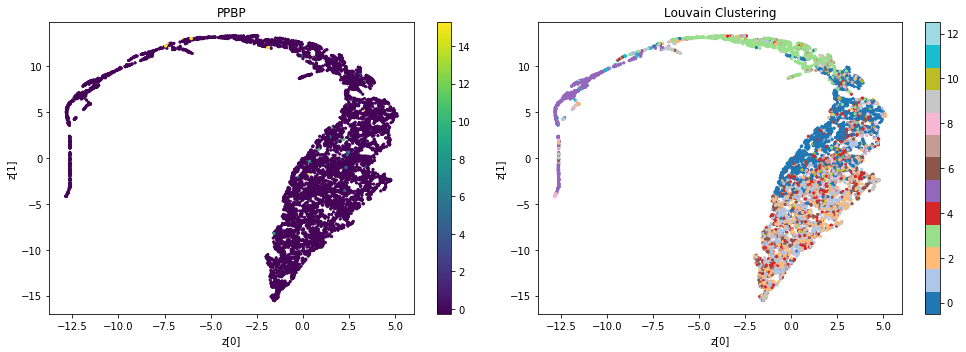

In [21]:
GENE_LIST = ['CST3', 'NKG7', 'PPBP']
model.plot_umap(gene_selected=GENE_LIST, louvain=True)

## Unsupervised Adversarial Autoencoder: Setting Clusters

### Build the model

In [4]:
# Network parameters

LATENT_DIM = 10
NUM_CLUSTERS = 10
LAYERS_ENC_DIM = [200, 100, 50]
LAYERS_DEC_DIM = [50, 100, 200]
LAYERS_DIS_DIM = [200, 100, 50]
LAYERS_DIS_CAT_DIM = [200, 100, 50]

BATCH_SIZE = 35
EPOCHS = 200
TEMPERATURE = 0.05

In [5]:
model = AAE5(latent_dim=LATENT_DIM,
             num_clusters=NUM_CLUSTERS,
             layers_enc_dim=LAYERS_ENC_DIM,
             layers_dec_dim=LAYERS_DEC_DIM,
             layers_dis_dim=LAYERS_DIS_DIM,
             layers_dis_cat_dim=LAYERS_DIS_CAT_DIM,
             batch_size=BATCH_SIZE,
             epochs=EPOCHS,
             tau=TEMPERATURE)

In [6]:
# Import dataset

data_path = '../data/proc/pbmc10k.h5ad'

model.load_data(data_path)

Dataset imported.


In [7]:
# Rescale gene expression data

model.rescale_data()

Gene expression data rescaled.


In [8]:
# Show network hyper-parameters

print("List of Network parameters")
model.get_parameters()

List of Network parameters


Value  \
batch_size                       35   
epochs                          200   
alpha                           0.1   
do_rate                         0.1   
kernel_initializer   glorot_uniform   
bias_initializer              zeros   
l2_weight                      0.01   
l1_weight                      0.01   
latent_dim                       10   
layer_1_enc_dim                 200   
layer_2_enc_dim                 100   
layer_3_enc_dim                  50   
layer_1_dec_dim                  50   
layer_2_dec_dim                 100   
layer_3_dec_dim                 200   
lr_ae                        0.0002   
dr_ae                         1e-06   
layer_1_dis_dim                 200   
layer_2_dis_dim                 100   
layer_3_dis_dim                  50   
lr_dis                       0.0001   
dr_dis                        1e-06   
lr_gen                       0.0001   
dr_gen                        1e-06   
layer_1_dis_cat_dim           200.0   
layer_2_dis_cat_dim           100.0   
layer_3_dis_cat_dim            50.0   
lr_dis_cat                   0.0001   
dr_dis_cat                    1e-06   
tau                            0.05   
num_clusters                   10.0   

                                                       Description  
batch_size                                              batch size  
epochs                                            number of epochs  
alpha                          alpha coeff. in activation function  
do_rate                                               dropout rate  
kernel_initializer          kernel initializer of all dense layers  
bias_initializer              bias initializer of all dense layers  
l2_weight                       weight of l2 kernel regularization  
l1_weight                     weight of l1 activity regularization  
latent_dim                             dimension of latent space Z  
layer_1_enc_dim                 dimension of encoder dense layer 1  
layer_2_enc_dim                 dimension of encoder dense layer 2  
layer_3_enc_dim                 dimension of encoder dense layer 3  
layer_1_dec_dim                 dimension of decoder dense layer 1  
layer_2_dec_dim                 dimension of decoder dense layer 2  
layer_3_dec_dim                 dimension of decoder dense layer 3  
lr_ae                                 learning rate of autoencoder  
dr_ae                                    decay rate of autoencoder  
layer_1_dis_dim           dimension of discriminator dense layer 1  
layer_2_dis_dim           dimension of discriminator dense layer 2  
layer_3_dis_dim           dimension of discriminator dense layer 3  
lr_dis                              learning rate of discriminator  
dr_dis                                 decay rate of discriminator  
lr_gen                                  learning rate of generator  
dr_gen                                     decay rate of generator  
layer_1_dis_cat_dim  dimension of cat. discriminator dense layer 1  
layer_2_dis_cat_dim  dimension of cat. discriminator dense layer 2  
layer_3_dis_cat_dim  dimension of cat. discriminator dense layer 3  
lr_dis_cat                     learning rate of cat. discriminator  
dr_dis_cat                        decay rate of cat. discriminator  
tau                                          temperature parameter  
num_clusters                     number of clusters in the dateset

In [9]:
# Build the full model

model.build_model()

In [10]:
# Model summary

model.get_summary()


Encoder Network
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
X (InputLayer)                  (None, 1789)         0                                            
__________________________________________________________________________________________________
H_1 (Dense)                     (None, 200)          358000      X[0][0]                          
__________________________________________________________________________________________________
BN_1 (BatchNormalization)       (None, 200)          800         H_1[0][0]                        
__________________________________________________________________________________________________
LR_1 (LeakyReLU)                (None, 200)          0           BN_1[0][0]                       
____________________________________________________________________________________________

Non-trainable params: 0
__________________________________________________________________________________________________

Autoencoder Network
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
X (InputLayer)                  (None, 1789)         0                                            
__________________________________________________________________________________________________
encoder (Model)                 [(None, 10), (None,  391580      X[0][0]                          
__________________________________________________________________________________________________
decoder (Model)                 (None, 1789)         385939      encoder[2][2]                    
                                                                 encoder[2][3]                    
________________________________________________________________

In [11]:
# Export model graphs

os.makedirs('../graphs/AAE5/PBMC10k', exist_ok=True)
model.export_graph('../graphs/AAE5/PBMC10k')

Model graphs saved.



### Visualize graphs


ENCODER


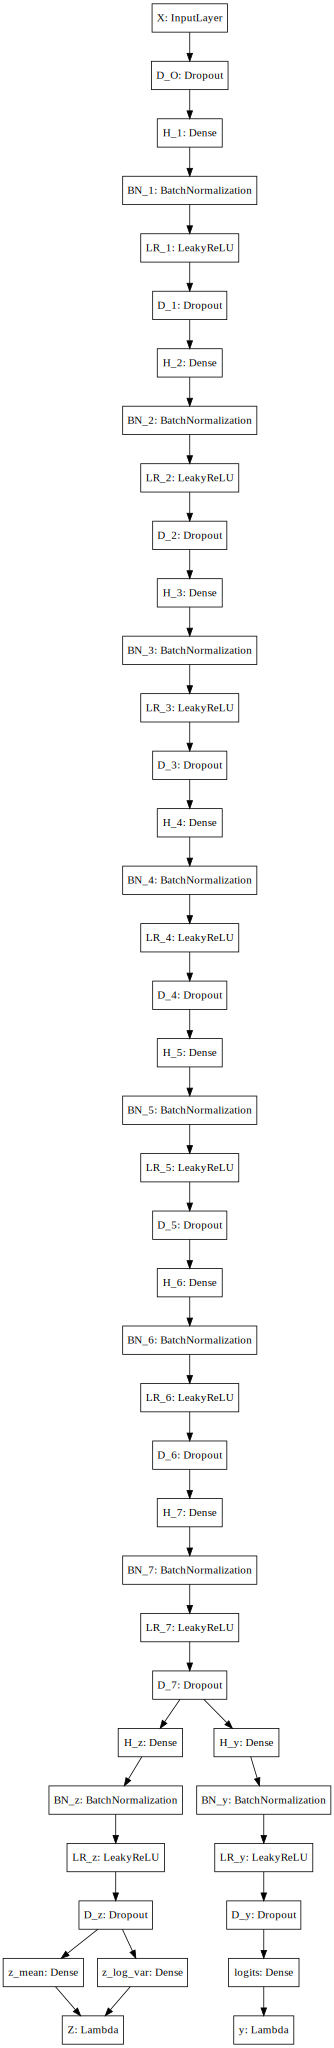

In [12]:
print("\nENCODER")
print("=======")
SVG(model_to_dot(model.encoder).create(prog='dot', format='svg'))


DECODER


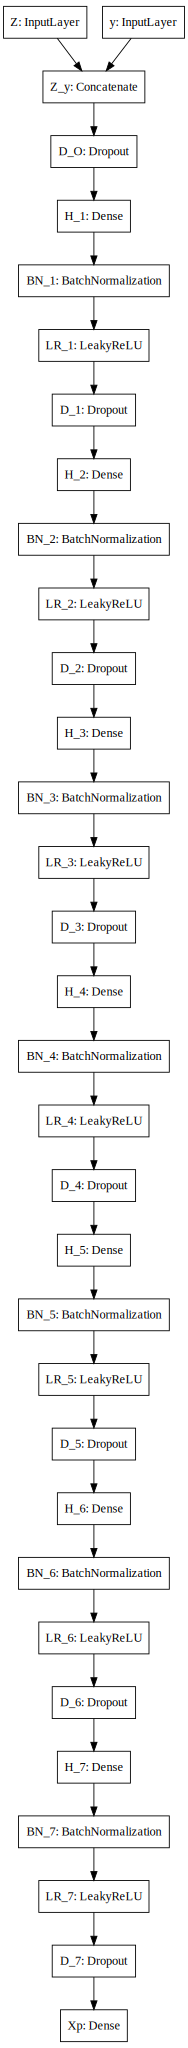

In [13]:
print("\nDECODER")
print("=======")
SVG(model_to_dot(model.decoder).create(prog='dot', format='svg'))


AUTOENCODER


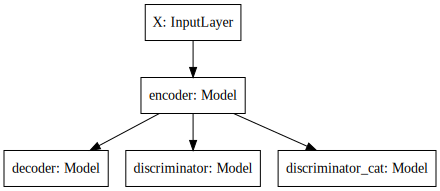

In [14]:
print("\nAUTOENCODER")
print("===========")
SVG(model_to_dot(model.autoencoder).create(prog='dot', format='svg'))


DISCRIMINATOR


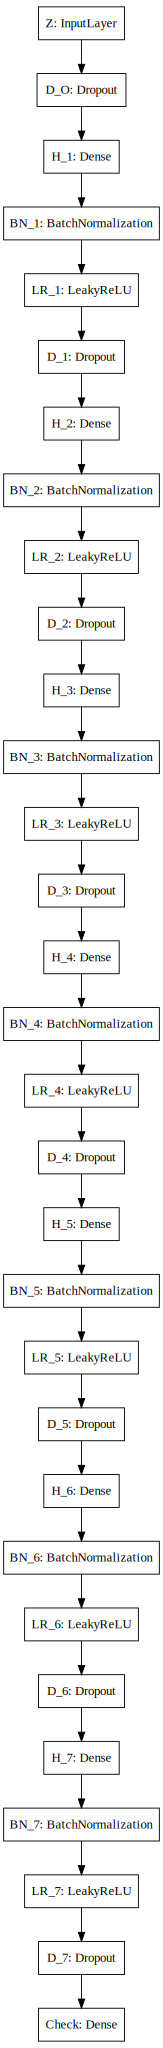

In [15]:
print("\nDISCRIMINATOR")
print("=============")
SVG(model_to_dot(model.discriminator).create(prog='dot', format='svg'))


CATEGORICAL DISCRIMINATOR


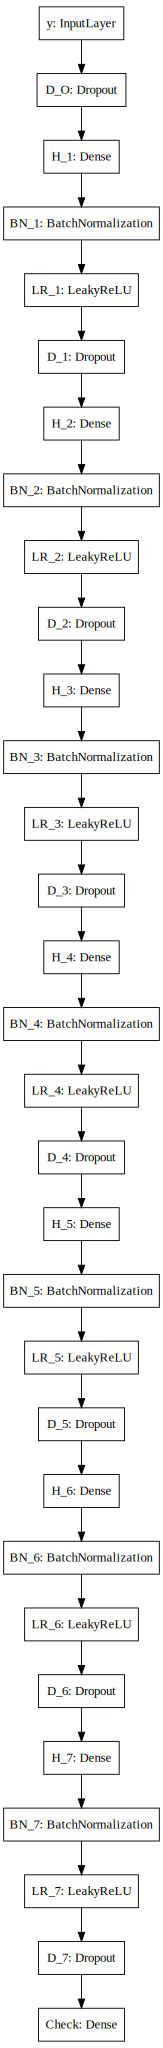

In [16]:
print("\nCATEGORICAL DISCRIMINATOR")
print("=========================")
SVG(model_to_dot(model.discriminator_cat).create(prog='dot', format='svg'))

### Train the model


Epoch 200/200, rec. loss: 109.387016, val. loss: 87.289467, dis. loss: 56.103153, cat. dis. loss: 22.072704


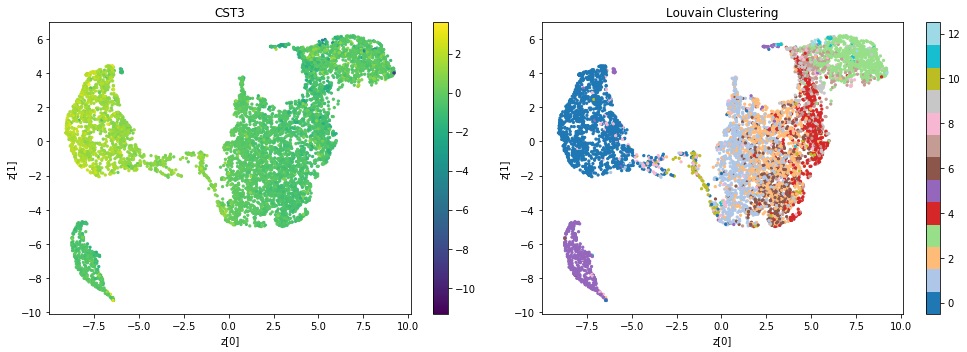

Training completed.


In [12]:
# graph=True to show the data points in the 2-D latent space

GENE = 'CST3' # used only for training visualization 

rec_loss, val_loss, dis_loss, dis_cat_loss = model.train(graph=True, gene=GENE)

In [13]:
# save models in h5 format
os.makedirs('../models/AAE5/PBMC10k', exist_ok=True)
model.export_model('../models/AAE5/PBMC10k')

All networks exported in h5 format.


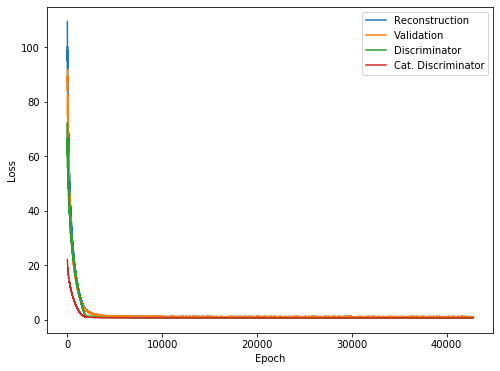

In [14]:
# Plot training loss values

plt.figure(figsize=(8, 6))
axes = plt.gca()
plt.plot(rec_loss)
plt.plot(val_loss)
plt.plot(dis_loss)
plt.plot(dis_cat_loss)
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Reconstruction', 'Validation', 'Discriminator', 'Cat. Discriminator'], 
           loc='upper right')
plt.show()

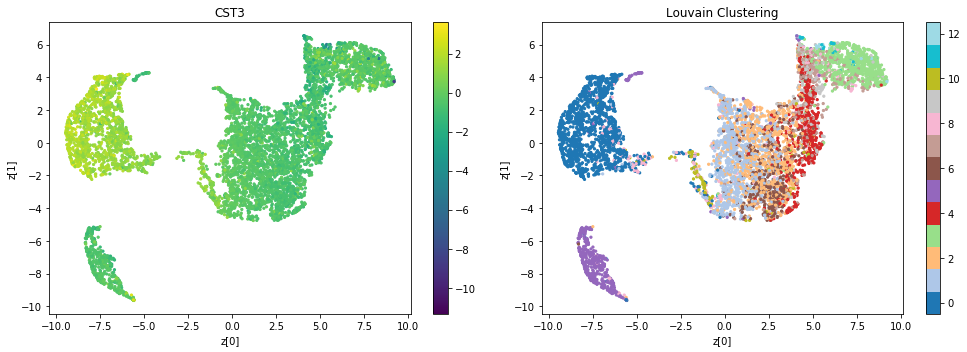

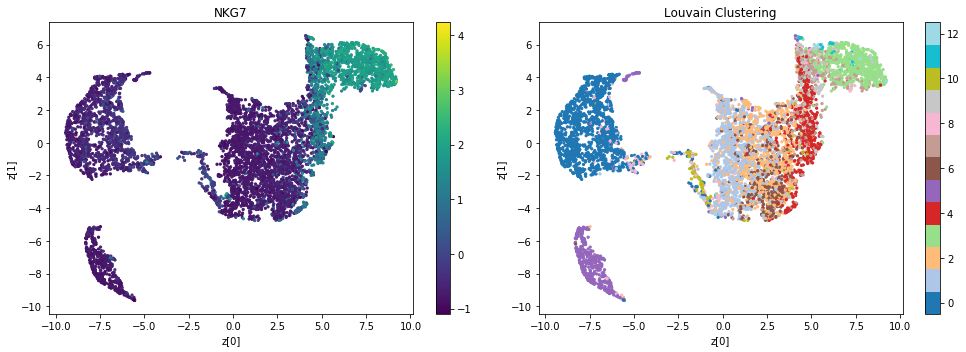

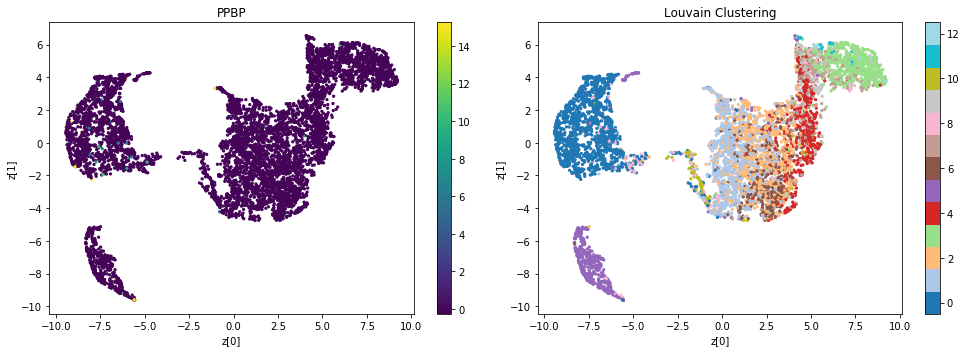

In [15]:
GENE_LIST = ['CST3', 'NKG7', 'PPBP']
model.plot_umap(gene_selected=GENE_LIST, louvain=True)

In [29]:
len(train_data_ids)

6000

In [30]:
len(test_data_ids)

1500

## Variational Autoencoder

<img src="img/variational_autoencoder_model.png" width="800px" style="float:center">

In [37]:
import numpy as np
import keras

class BatchGenerator(keras.utils.Sequence):
    """
    Batch generator

    """
    def __init__(self, X0, y0, batch_size=32, shuffle=True):
        'Initialization'
        self.X0 = X0
        self.y0 = y0
        self.batch_size = batch_size
        self.list_IDs = np.array(range(self.X0.shape[0]))
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index * self.batch_size:(index + 1) * self.batch_size]

        # Find list of IDs
        list_IDs_temp = [self.list_IDs[k] for k in indexes]

        # Generate data
        X, y = self.__data_generation(list_IDs_temp)

        return X, None

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, list_IDs_temp):
        'Generates data containing batch_size samples'  
        # Initialization
        X = np.empty((self.batch_size, *self.X0.shape[1:]))
        y = np.empty((self.batch_size, *self.y0.shape[1:]))

        # Generate data
        for i, _ in enumerate(list_IDs_temp):
            # Store sample
            X[i,] = self.X0[i,]

            # Store class
            y[i,] = self.y0[i,]

        return X, y


In [40]:
from sklearn.model_selection import train_test_split
tot = np.array(range(len(model.data)))

train_ids, test_ids = train_test_split(tot, test_size=0.2, random_state=42)

training_generator = BatchGenerator(model.data[train_ids], np.array(model.labels)[train_ids])
validation_generator = BatchGenerator(model.data[test_ids], np.array(model.labels)[train_ids])

model.autoencoder.fit_generator(generator=training_generator,
                                validation_data=validation_generator,
                                use_multiprocessing=True,
                                workers=4,
                                epochs=10)



Epoch 1/10
187/187 [==============================] - 4s 21ms/step - loss: 1749.8861 - val_loss: 1842.0229
Epoch 2/10
187/187 [==============================] - 4s 21ms/step - loss: 1736.1083 - val_loss: 1832.8218
Epoch 3/10
187/187 [==============================] - 4s 20ms/step - loss: 1719.4048 - val_loss: 1824.2734
Epoch 4/10
187/187 [==============================] - 4s 19ms/step - loss: 1691.7206 - val_loss: 1815.9062
Epoch 5/10
187/187 [==============================] - 4s 20ms/step - loss: 1657.5027 - val_loss: 1808.2503
Epoch 6/10
187/187 [==============================] - 4s 20ms/step - loss: 1632.2495 - val_loss: 1807.5410
Epoch 7/10
187/187 [==============================] - 4s 19ms/step - loss: 1615.7768 - val_loss: 1800.0693
Epoch 8/10
187/187 [==============================] - 4s 20ms/step - loss: 1604.5946 - val_loss: 1795.3724
Epoch 9/10
187/187 [==============================] - 3s 18ms/step - loss: 1596.9215 - val_loss: 1792.4482
Epoch 10/10
187/187 [================

### Build the model

In [4]:
# Network parameters

LATENT_DIM = 10
LAYERS_ENC_DIM = [200, 100, 50, 50, 40, 30, 30, LATENT_DIM]
LAYERS_DEC_DIM = [LATENT_DIM, 30, 30, 40, 50, 50, 100, 200]

BATCH_SIZE = 35
EPOCHS = 500

In [5]:
model = VAE(latent_dim=LATENT_DIM,
            layers_enc_dim=LAYERS_ENC_DIM,
            layers_dec_dim=LAYERS_DEC_DIM,
            batch_size=BATCH_SIZE,
            epochs=EPOCHS)

In [6]:
from keras import backend as K
K.clear_session()  # clear default graph

model = VAE2(latent_dim=LATENT_DIM,
             layers_enc_dim=LAYERS_ENC_DIM,
             layers_dec_dim=LAYERS_DEC_DIM,
             batch_size=BATCH_SIZE,
             epochs=EPOCHS)

In [7]:
# Import dataset

data_path = '../data/proc/pbmc10k.h5ad'

model.load_data(data_path)

Dataset imported.


In [8]:
# Rescale gene expression data

model.rescale_data()

Gene expression data rescaled.


In [9]:
# Show network hyper-parameters

print("List of Network parameters")
model.get_parameters()

List of Network parameters


Value                             Description
batch_size                      35                              batch size
epochs                         500                        number of epochs
alpha                          0.1     alpha coeff. in activation function
do_rate                        0.1                            dropout rate
kernel_initializer  glorot_uniform  kernel initializer of all dense layers
bias_initializer             zeros    bias initializer of all dense layers
l2_weight                     0.01      weight of l2 kernel regularization
l1_weight                     0.01    weight of l1 activity regularization
latent_dim                      10             dimension of latent space Z
layer_1_enc_dim                200      dimension of encoder dense layer 1
layer_2_enc_dim                100      dimension of encoder dense layer 2
layer_3_enc_dim                 50      dimension of encoder dense layer 3
layer_4_enc_dim                 50      dimension of encoder dense layer 4
layer_5_enc_dim                 40      dimension of encoder dense layer 5
layer_6_enc_dim                 30      dimension of encoder dense layer 6
layer_7_enc_dim                 30      dimension of encoder dense layer 7
layer_8_enc_dim                 10      dimension of encoder dense layer 8
layer_1_dec_dim                 10      dimension of decoder dense layer 1
layer_2_dec_dim                 30      dimension of decoder dense layer 2
layer_3_dec_dim                 30      dimension of decoder dense layer 3
layer_4_dec_dim                 40      dimension of decoder dense layer 4
layer_5_dec_dim                 50      dimension of decoder dense layer 5
layer_6_dec_dim                 50      dimension of decoder dense layer 6
layer_7_dec_dim                100      dimension of decoder dense layer 7
layer_8_dec_dim                200      dimension of decoder dense layer 8
lr_ae                       0.0002            learning rate of autoencoder
dr_ae                        1e-06               decay rate of autoencoder

In [10]:
# Build the full model

model.build_model()

In [11]:
# Model summary

model.get_summary()


Encoder Network
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
X (InputLayer)                  (None, 1789)         0                                            
__________________________________________________________________________________________________
D_O (Dropout)                   (None, 1789)         0           X[0][0]                          
__________________________________________________________________________________________________
H_1 (Dense)                     (None, 200)          357800      D_O[0][0]                        
__________________________________________________________________________________________________
BN_1 (BatchNormalizationV1)     (None, 200)          800         H_1[0][0]                        
____________________________________________________________________________________________

_________________________________________________________________
LR_3 (LeakyReLU)             (None, 30)                0         
_________________________________________________________________
D_3 (Dropout)                (None, 30)                0         
_________________________________________________________________
H_4 (Dense)                  (None, 40)                1200      
_________________________________________________________________
BN_4 (BatchNormalizationV1)  (None, 40)                160       
_________________________________________________________________
LR_4 (LeakyReLU)             (None, 40)                0         
_________________________________________________________________
D_4 (Dropout)                (None, 40)                0         
_________________________________________________________________
H_5 (Dense)                  (None, 50)                2000      
_________________________________________________________________
BN_5 (Batc

In [12]:
# Export model graphs

os.makedirs('../graphs/VAE/PBMC10k', exist_ok=True)
model.export_graph('../graphs/VAE/PBMC10k')

Model graphs saved.



### Visualize graphs


ENCODER


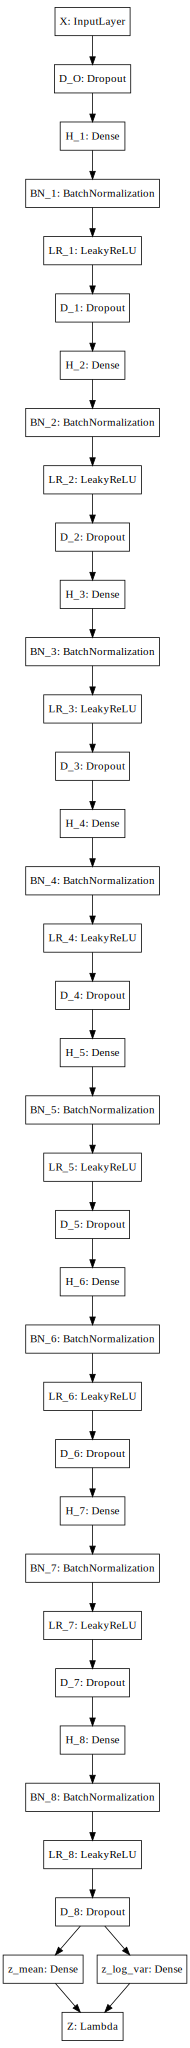

In [12]:
print("\nENCODER")
print("=======")
SVG(model_to_dot(model.encoder).create(prog='dot', format='svg'))


DECODER


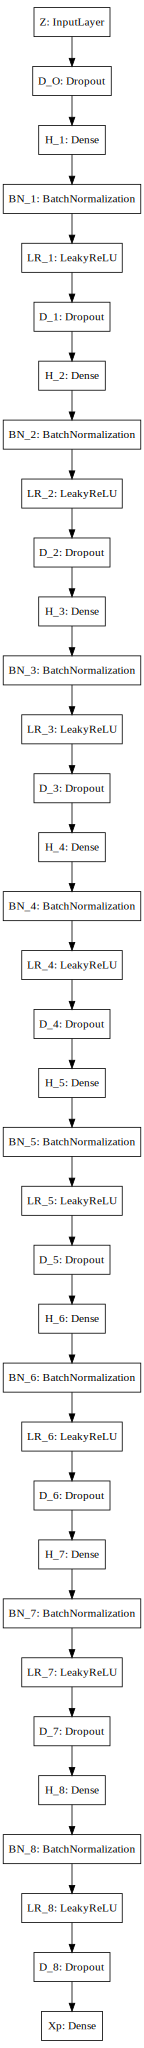

In [13]:
print("\nDECODER")
print("=======")
SVG(model_to_dot(model.decoder).create(prog='dot', format='svg'))


AUTOENCODER


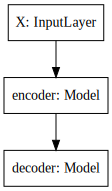

In [14]:
print("\nAUTOENCODER")
print("===========")
SVG(model_to_dot(model.autoencoder).create(prog='dot', format='svg'))

### Train the model

In [ ]:
loss, val_loss = model.train(val_split=0.2)

Start model training...
Train on 6000 samples, validate on 1500 samples
Epoch 1/500
6000/6000 [==============================] - 9s 1ms/sample - loss: 1988.3151 - val_loss: 2003.4599
Epoch 2/500
6000/6000 [==============================] - 3s 486us/sample - loss: 1825.6119 - val_loss: 1873.7644
Epoch 3/500
6000/6000 [==============================] - 3s 489us/sample - loss: 1802.8847 - val_loss: 1847.1693
Epoch 4/500
6000/6000 [==============================] - 3s 492us/sample - loss: 1795.8364 - val_loss: 1839.4437
Epoch 5/500
6000/6000 [==============================] - 3s 517us/sample - loss: 1792.7323 - val_loss: 1836.4801
Epoch 6/500
6000/6000 [==============================] - 3s 533us/sample - loss: 1791.0119 - val_loss: 1834.6150
Epoch 7/500
6000/6000 [==============================] - 3s 503us/sample - loss: 1789.8232 - val_loss: 1833.1022
Epoch 8/500
6000/6000 [==============================] - 3s 488us/sample - loss: 1788.9887 - val_loss: 1832.7229
Epoch 9/500
6000/6000 [===

6000/6000 [==============================] - 3s 542us/sample - loss: 1705.0508 - val_loss: 1737.5327
Epoch 73/500
6000/6000 [==============================] - 3s 516us/sample - loss: 1705.4374 - val_loss: 1737.4404
Epoch 74/500
6000/6000 [==============================] - 3s 508us/sample - loss: 1705.4391 - val_loss: 1737.5501
Epoch 75/500
6000/6000 [==============================] - 3s 501us/sample - loss: 1703.5064 - val_loss: 1737.7925
Epoch 76/500
6000/6000 [==============================] - 3s 531us/sample - loss: 1705.4851 - val_loss: 1736.3711
Epoch 77/500
6000/6000 [==============================] - 3s 519us/sample - loss: 1704.5063 - val_loss: 1738.0086
Epoch 78/500
6000/6000 [==============================] - 3s 471us/sample - loss: 1704.2987 - val_loss: 1737.2707
Epoch 79/500
6000/6000 [==============================] - 3s 495us/sample - loss: 1703.3656 - val_loss: 1736.4539
Epoch 80/500
6000/6000 [==============================] - 4s 689us/sample - loss: 1703.4172 - val_los

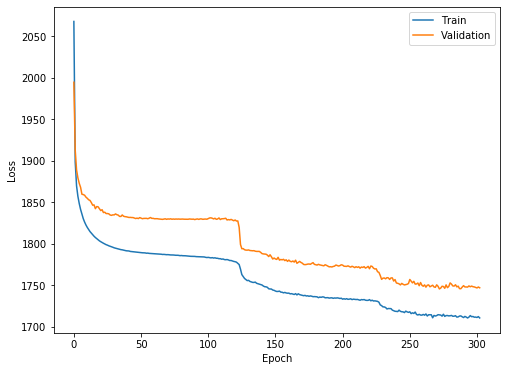

In [16]:
# Plot training & validation loss values

plt.figure(figsize=(8, 6))
axes = plt.gca()
plt.plot(loss)
plt.plot(val_loss)
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

In [17]:
# save models in h5 format
os.makedirs('../models/VAE/PBMC10k', exist_ok=True)
model.export_model('../models/VAE/PBMC10k')

All networks exported in h5 format.


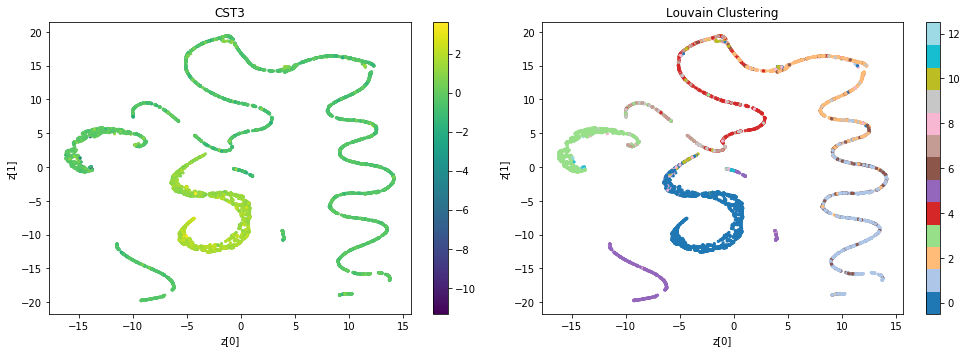

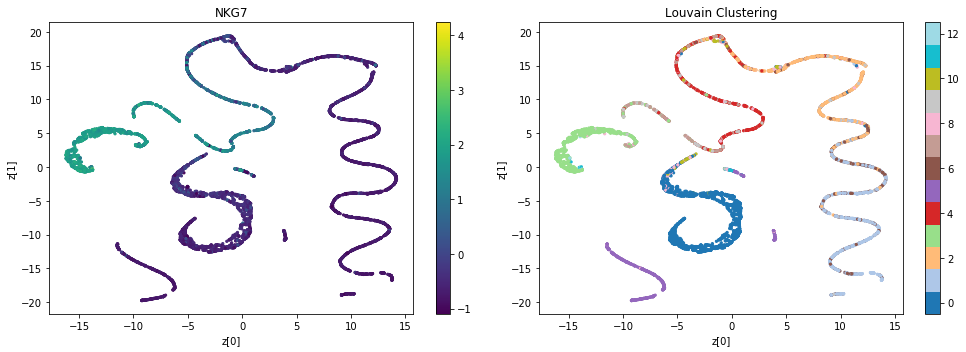

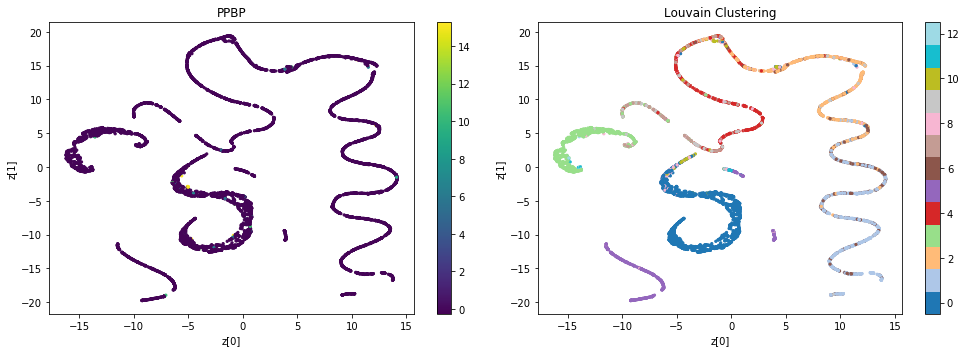

In [18]:
gene_list = ['CST3', 'NKG7', 'PPBP']
model.plot_umap(gene_selected=gene_list, louvain=True)

# Clustering analysis on 8k PBMC data

In [1]:
from keras.utils.vis_utils import model_to_dot
from keras.utils import normalize, to_categorical
from IPython.display import SVG

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scanpy as sc
import os

from imp import load_source
from utils import plot_results_pca, plot_results_umap, plot_results_louvain
from models import *

Using TensorFlow backend.


In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
from tensorflow.python.util import deprecation
deprecation._PRINT_DEPRECATION_WARNINGS = False

## Adversarial Autoencoder: Basic Architecture

<img src="img/adversarial_autoencoder_model.png" width="800px" style="float:center" >

### Build the model

In [4]:
# Network parameters

layers_enc_dim = [100,50,50]
layers_dec_dim = [50,50,100]
layers_dis_dim = [50,50,100]
batch_size = 35
latent_dim = 50
epochs = 50

In [5]:
model = AAE1(latent_dim=latent_dim,
             layers_enc_dim=layers_enc_dim, 
             layers_dec_dim=layers_dec_dim, 
             layers_dis_dim=layers_dis_dim,
             batch_size=batch_size,
             epochs=epochs)

In [6]:
# Import dataset

data_path = '../data/proc/pbmc8k.h5ad'

model.load_data(data_path)

Dataset imported.


In [7]:
# Rescale gene expression data

model.rescale_data()

Gene expression data rescaled.


In [8]:
# Show network hyper-parameters

print("List of Network parameters")
model.get_parameters()

List of Network parameters


Value                               Description
latent_dim                      50               dimension of latent space Z
layer_1_enc_dim                100        dimension of encoder dense layer 1
layer_2_enc_dim                 50        dimension of encoder dense layer 2
layer_3_enc_dim                 50        dimension of encoder dense layer 3
layer_1_dec_dim                 50        dimension of decoder dense layer 1
layer_2_dec_dim                 50        dimension of decoder dense layer 2
layer_3_dec_dim                100        dimension of decoder dense layer 3
layer_1_dis_dim                 50  dimension of discriminator dense layer 1
layer_2_dis_dim                 50  dimension of discriminator dense layer 2
layer_3_dis_dim                100  dimension of discriminator dense layer 3
alpha                          0.1       alpha coeff. in activation function
do_rate                        0.1                              dropout rate
kernel_initializer  glorot_uniform    kernel initializer of all dense layers
bias_initializer             zeros      bias initializer of all dense layers
l2_weight                     0.01        weight of l2 kernel regularization
l2_weight                     0.01      weight of l1 activity regularization
batch_size                      35                                batch size
epochs                          50                          number of epochs
lr_dis                      0.0001               learning rate discriminator
lr_gen                      0.0001                   learning rate generator
lr_ae                       0.0002                 learning rate autoencoder
dr_dis                       1e-06                  decay rate discriminator
dr_gen                       1e-06                      decay rate generator
dr_ae                        1e-06                    decay rate autoencoder

In [9]:
# Build the full model

model.build_model()

In [10]:
# Model summary

model.get_summary()


Encoder Network
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
X (InputLayer)                  (None, 1330)         0                                            
__________________________________________________________________________________________________
D_O (Dropout)                   (None, 1330)         0           X[0][0]                          
__________________________________________________________________________________________________
H_1 (Dense)                     (None, 100)          133000      D_O[0][0]                        
__________________________________________________________________________________________________
BN_1 (BatchNormalization)       (None, 100)          400         H_1[0][0]                        
____________________________________________________________________________________________

In [13]:
# Export model graphs

os.makedirs('../graphs/AAE1/PBMC8k', exist_ok=True)
model.export_graph('../graphs/AAE1/PBMC8k')

Model graphs saved.



### Visualize graphs


ENCODER


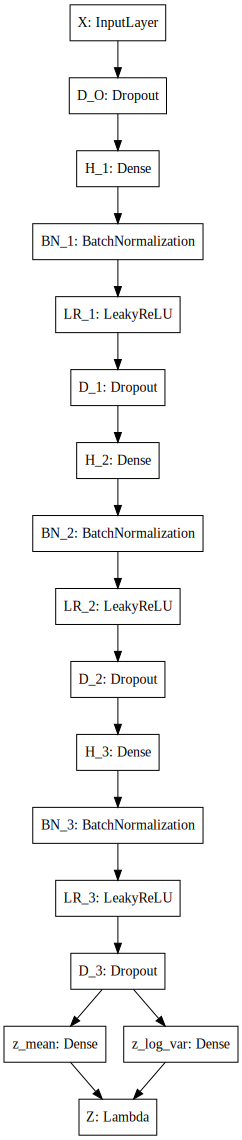

In [16]:
print("\nENCODER")
print("=======")
SVG(model_to_dot(model.encoder).create(prog='dot', format='svg'))


DECODER


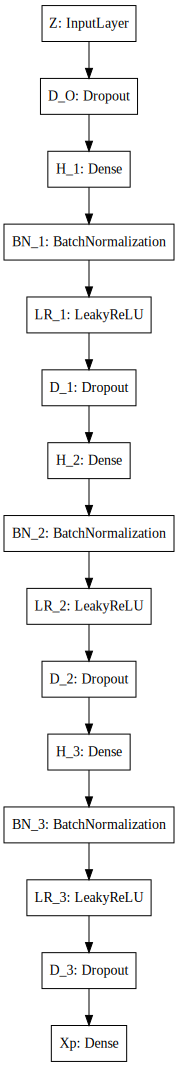

In [17]:
print("\nDECODER")
print("=======")
SVG(model_to_dot(model.decoder).create(prog='dot', format='svg'))


AUTOENCODER


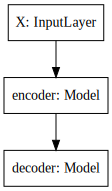

In [18]:
print("\nAUTOENCODER")
print("===========")
SVG(model_to_dot(model.autoencoder).create(prog='dot', format='svg'))


GENERATOR


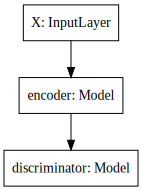

In [23]:
print("\nGENERATOR")
print("=========")
SVG(model_to_dot(model.generator).create(prog='dot', format='svg'))


DISCRIMINATOR


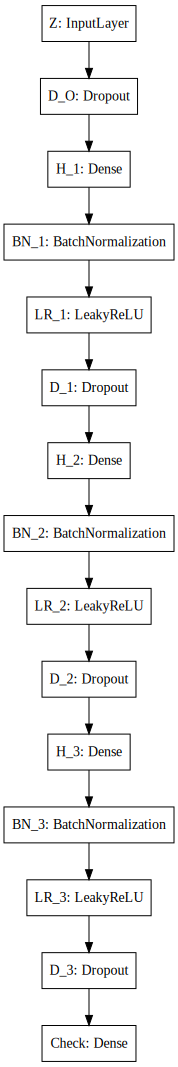

In [19]:
print("\nDISCRIMINATOR")
print("=============")
SVG(model_to_dot(model.discriminator).create(prog='dot', format='svg'))

### Train the model

Epoch 50/50, reconstruction loss: 1.037190, generation loss: 0.409361, discriminator loss: 0.307326


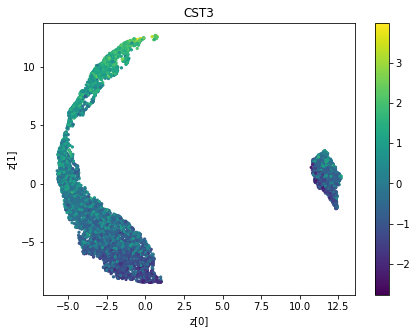

Training completed.


In [11]:
# graph=True to show the data points in the 2-D latent space

gene = 'CST3' # used only for training visualization 

rec_loss, gen_loss, dis_loss = model.train(graph=True, gene=gene)

In [16]:
# save models in h5 format
os.makedirs('../models/AAE1/PBMC8k', exist_ok=True)
model.export_model('../models/AAE1/PBMC8k')

Adversarial Autoencoder networks exported in h5 format.


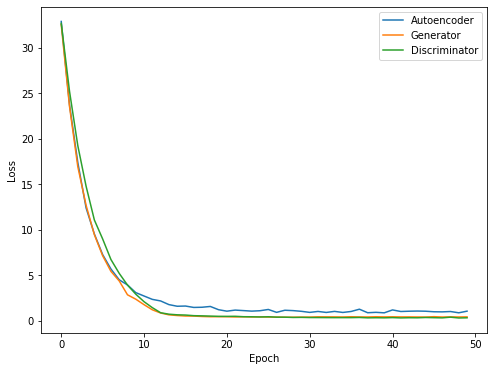

In [12]:
# Plot training & validation loss values

plt.figure(figsize=(8, 6))
axes = plt.gca()
plt.plot(rec_loss)
plt.plot(gen_loss)
plt.plot(dis_loss)
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Autoencoder', 'Generator', 'Discriminator'], loc='upper right')
plt.show()

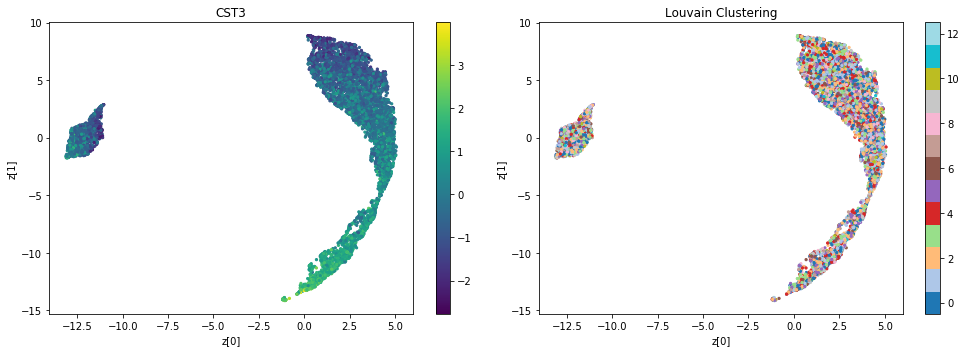

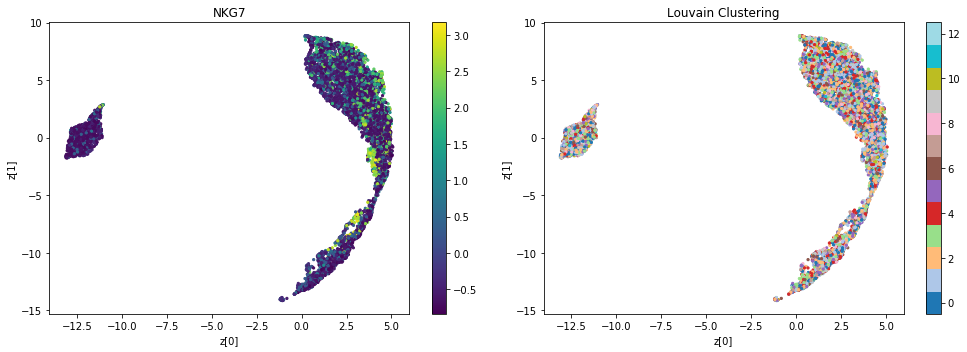

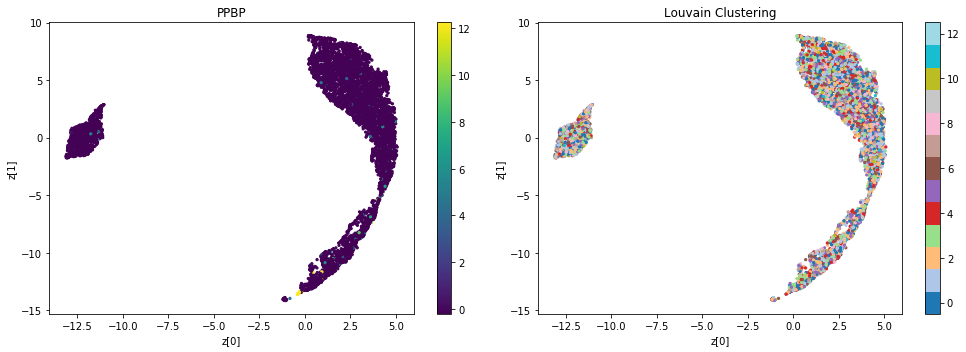

In [13]:
gene_list = ['CST3', 'NKG7', 'PPBP']
model.plot_umap(gene_selected=gene_list, louvain=True)

## Incorporating Label Information in the Adversarial Regularization

### Build the model

In [4]:
# Network parameters

layers_enc_dim = [100,50,50]
layers_dec_dim = [50,50,100]
layers_dis_dim = [50,50,100]
batch_size = 35
latent_dim = 50
epochs = 50

In [5]:
model = AAE2(latent_dim=latent_dim,
             layers_enc_dim=layers_enc_dim, 
             layers_dec_dim=layers_dec_dim, 
             layers_dis_dim=layers_dis_dim,
             batch_size=batch_size,
             epochs=epochs)

In [6]:
# Import dataset

data_path = '../data/proc/pbmc8k.h5ad'

model.load_data(data_path)

Dataset imported.


In [7]:
# Rescale gene expression data

model.rescale_data()

Gene expression data rescaled.


In [8]:
# Show network hyper-parameters

print("List of Network parameters")
model.get_parameters()

List of Network parameters


Value                               Description
latent_dim                      50               dimension of latent space Z
layer_1_enc_dim                100        dimension of encoder dense layer 1
layer_2_enc_dim                 50        dimension of encoder dense layer 2
layer_3_enc_dim                 50        dimension of encoder dense layer 3
layer_1_dec_dim                 50        dimension of decoder dense layer 1
layer_2_dec_dim                 50        dimension of decoder dense layer 2
layer_3_dec_dim                100        dimension of decoder dense layer 3
layer_1_dis_dim                 50  dimension of discriminator dense layer 1
layer_2_dis_dim                 50  dimension of discriminator dense layer 2
layer_3_dis_dim                100  dimension of discriminator dense layer 3
alpha                          0.1       alpha coeff. in activation function
do_rate                        0.1                              dropout rate
kernel_initializer  glorot_uniform    kernel initializer of all dense layers
bias_initializer             zeros      bias initializer of all dense layers
l2_weight                     0.01        weight of l2 kernel regularization
l2_weight                     0.01      weight of l1 activity regularization
batch_size                      35                                batch size
epochs                          50                          number of epochs
lr_dis                      0.0001               learning rate discriminator
lr_gen                      0.0001                   learning rate generator
lr_ae                       0.0002                 learning rate autoencoder
dr_dis                       1e-06                  decay rate discriminator
dr_gen                       1e-06                      decay rate generator
dr_ae                        1e-06                    decay rate autoencoder

In [9]:
# Build the full model

model.build_model()

In [10]:
# Model summary

model.get_summary()


Encoder Network
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
X (InputLayer)                  (None, 1330)         0                                            
__________________________________________________________________________________________________
D_O (Dropout)                   (None, 1330)         0           X[0][0]                          
__________________________________________________________________________________________________
H_1 (Dense)                     (None, 100)          133000      D_O[0][0]                        
__________________________________________________________________________________________________
BN_1 (BatchNormalization)       (None, 100)          400         H_1[0][0]                        
____________________________________________________________________________________________

In [11]:
# Export model graphs

os.makedirs('../graphs/AAE2/PBMC8k', exist_ok=True)
model.export_graph('../graphs/AAE2/PBMC8k')

Model graphs saved.



### Visualize graphs


ENCODER


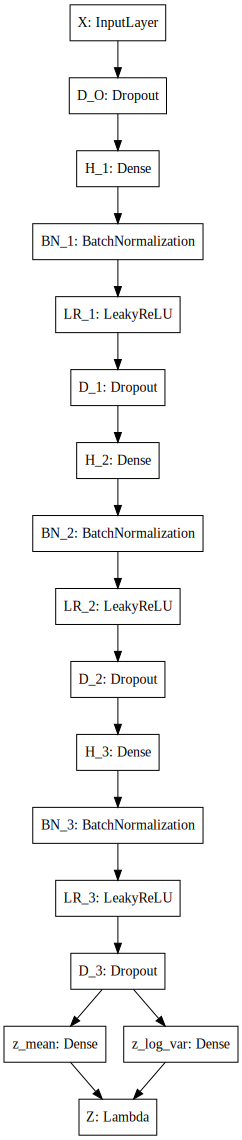

In [11]:
print("\nENCODER")
print("=======")
SVG(model_to_dot(model.encoder).create(prog='dot', format='svg'))


DECODER


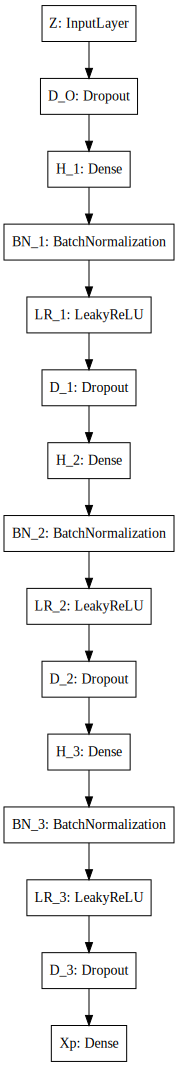

In [12]:
print("\nDECODER")
print("=======")
SVG(model_to_dot(model.decoder).create(prog='dot', format='svg'))


AUTOENCODER


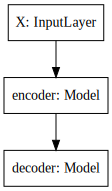

In [13]:
print("\nAUTOENCODER")
print("===========")
SVG(model_to_dot(model.autoencoder).create(prog='dot', format='svg'))


GENERATOR


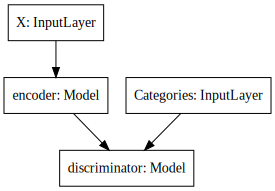

In [14]:
print("\nGENERATOR")
print("=========")
SVG(model_to_dot(model.generator).create(prog='dot', format='svg'))


DISCRIMINATOR


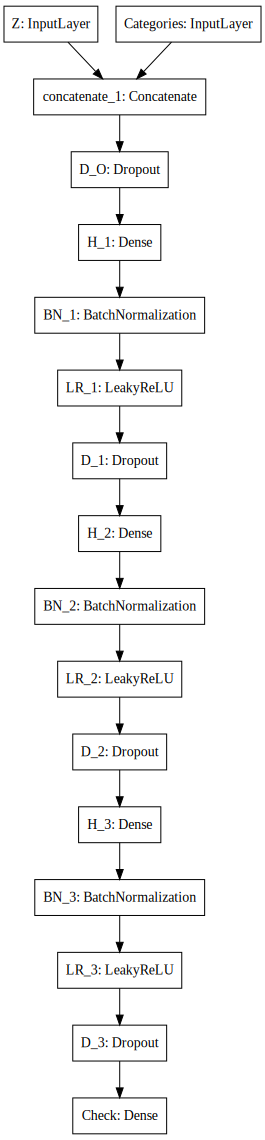

In [15]:
print("\nDISCRIMINATOR")
print("=============")
SVG(model_to_dot(model.discriminator).create(prog='dot', format='svg'))

### Train the model

Epoch 50/50, reconstruction loss: 1.010608, generation loss: 0.410127, discriminator loss: 0.271828


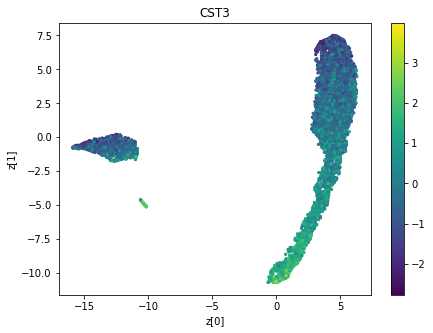

Training completed.


In [16]:
# graph=True to show the data points in the 2-D latent space

gene = 'CST3' # used only for training visualization 

rec_loss, gen_loss, dis_loss = model.train(graph=True, gene=gene)

In [18]:
# save models in h5 format
os.makedirs('../models/AAE2/PBMC8k', exist_ok=True)
model.export_model('../models/AAE2/PBMC8k')

All networks exported in h5 format.


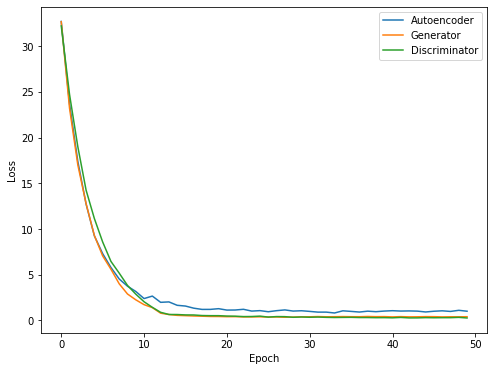

In [17]:
# Plot training & validation loss values

plt.figure(figsize=(8, 6))
axes = plt.gca()
plt.plot(rec_loss)
plt.plot(gen_loss)
plt.plot(dis_loss)
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Autoencoder', 'Generator', 'Discriminator'], loc='upper right')
plt.show()

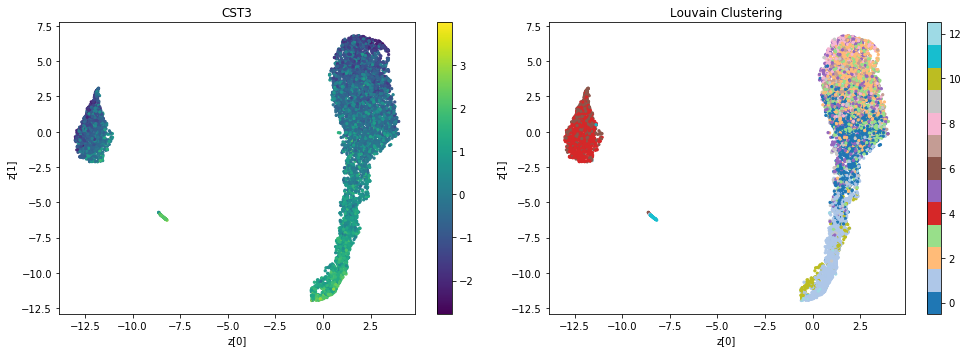

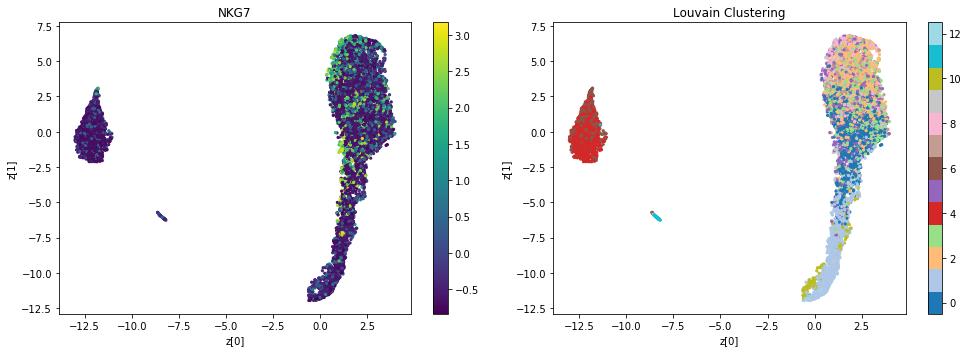

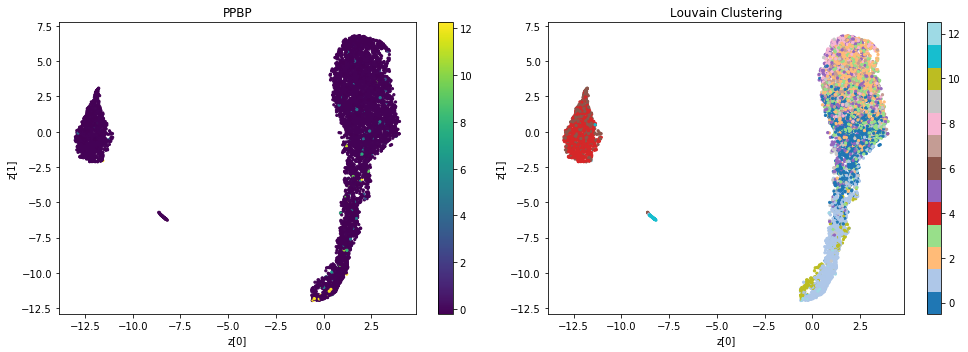

In [18]:
gene_list = ['CST3', 'NKG7', 'PPBP']
model.plot_umap(gene_selected=gene_list, louvain=True)

# Clustering analysis on 3k PBMC data


In [1]:
from keras.utils.vis_utils import model_to_dot
from keras.utils import normalize, to_categorical
from IPython.display import SVG

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scanpy as sc
import os

from imp import load_source
from utils import plot_results_pca, plot_results_umap, plot_results_louvain
from models import *

Using TensorFlow backend.


In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
from tensorflow.python.util import deprecation
deprecation._PRINT_DEPRECATION_WARNINGS = False

## Adversarial Autoencoder: Basic Architecture

<img src="img/adversarial_autoencoder_model.png" width="800px" style="float:center" >

### Build the model

In [4]:
# Network parameters

layers_enc_dim = [100,50,50]
layers_dec_dim = [50,50,100]
layers_dis_dim = [50,50,100]
batch_size = 35
latent_dim = 50
epochs = 50

In [5]:
model = AAE1(latent_dim=latent_dim,
             layers_enc_dim=layers_enc_dim, 
             layers_dec_dim=layers_dec_dim, 
             layers_dis_dim=layers_dis_dim,
             batch_size=batch_size,
             epochs=epochs)

In [6]:
# Import dataset

data_path = '../data/proc/pbmc3k.h5ad'

model.load_data(data_path)

Dataset imported.


In [7]:
# Rescale gene expression data

model.rescale_data()

Gene expression data rescaled.


In [8]:
# Show network hyper-parameters

print("List of Network parameters")
model.get_parameters()

List of Network parameters


Value                               Description
latent_dim                      50               dimension of latent space Z
layer_1_enc_dim                100        dimension of encoder dense layer 1
layer_2_enc_dim                 50        dimension of encoder dense layer 2
layer_3_enc_dim                 50        dimension of encoder dense layer 3
layer_1_dec_dim                 50        dimension of decoder dense layer 1
layer_2_dec_dim                 50        dimension of decoder dense layer 2
layer_3_dec_dim                100        dimension of decoder dense layer 3
layer_1_dis_dim                 50  dimension of discriminator dense layer 1
layer_2_dis_dim                 50  dimension of discriminator dense layer 2
layer_3_dis_dim                100  dimension of discriminator dense layer 3
alpha                          0.1       alpha coeff. in activation function
do_rate                        0.1                              dropout rate
kernel_initializer  glorot_uniform    kernel initializer of all dense layers
bias_initializer             zeros      bias initializer of all dense layers
l2_weight                     0.01        weight of l2 kernel regularization
l2_weight                     0.01      weight of l1 activity regularization
batch_size                      35                                batch size
epochs                          50                          number of epochs
lr_dis                      0.0001               learning rate discriminator
lr_gen                      0.0001                   learning rate generator
lr_ae                       0.0002                 learning rate autoencoder
dr_dis                       1e-06                  decay rate discriminator
dr_gen                       1e-06                      decay rate generator
dr_ae                        1e-06                    decay rate autoencoder

In [9]:
# Build the full model

model.build_model()

In [10]:
# Model summary

model.get_summary()


Encoder Network
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
X (InputLayer)                  (None, 1838)         0                                            
__________________________________________________________________________________________________
D_O (Dropout)                   (None, 1838)         0           X[0][0]                          
__________________________________________________________________________________________________
H_1 (Dense)                     (None, 100)          183800      D_O[0][0]                        
__________________________________________________________________________________________________
BN_1 (BatchNormalization)       (None, 100)          400         H_1[0][0]                        
____________________________________________________________________________________________

In [13]:
# Export model graphs

os.makedirs('../graphs/AAE1/PBMC3k', exist_ok=True)
model.export_graph('../graphs/AAE1/PBMC3k')

Model graphs saved.



### Visualize graphs


ENCODER


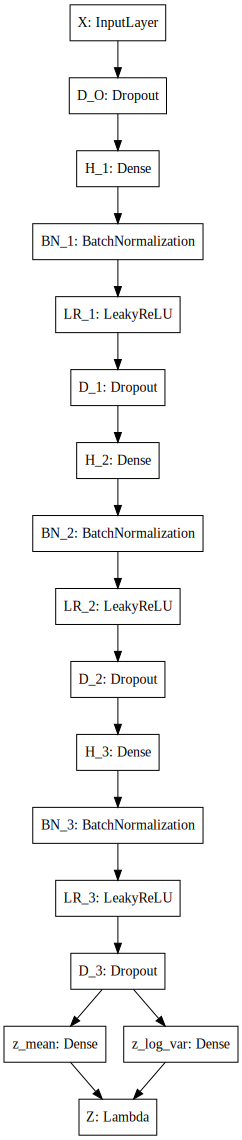

In [16]:
print("\nENCODER")
print("=======")
SVG(model_to_dot(model.encoder).create(prog='dot', format='svg'))


DECODER


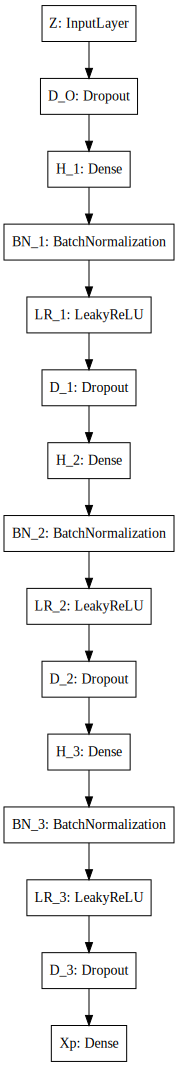

In [17]:
print("\nDECODER")
print("=======")
SVG(model_to_dot(model.decoder).create(prog='dot', format='svg'))


AUTOENCODER


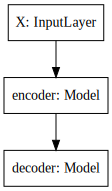

In [18]:
print("\nAUTOENCODER")
print("===========")
SVG(model_to_dot(model.autoencoder).create(prog='dot', format='svg'))


GENERATOR


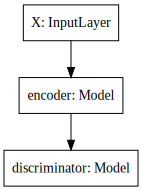

In [23]:
print("\nGENERATOR")
print("=========")
SVG(model_to_dot(model.generator).create(prog='dot', format='svg'))


DISCRIMINATOR


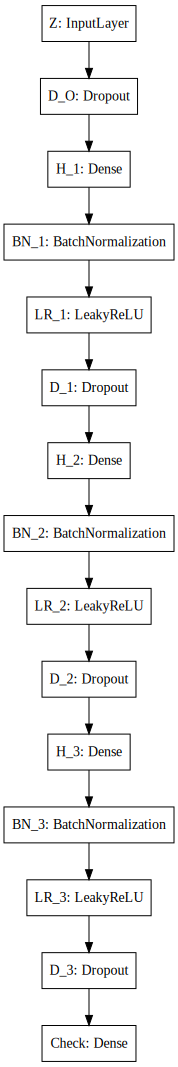

In [19]:
print("\nDISCRIMINATOR")
print("=============")
SVG(model_to_dot(model.discriminator).create(prog='dot', format='svg'))

### Train the model

Epoch 50/50, reconstruction loss: 1.316368, generation loss: 0.451401, discriminator loss: 0.551019


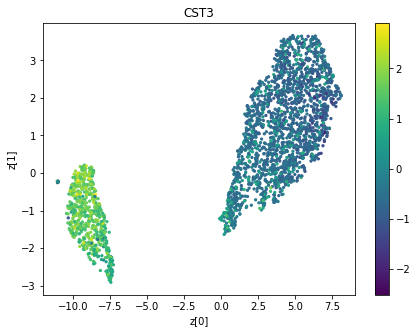

Training completed.


In [11]:
# graph=True to show the data points in the 2-D latent space

gene = 'CST3' # used only for training visualization 

rec_loss, gen_loss, dis_loss = model.train(graph=True, gene=gene)

In [16]:
# save models in h5 format
os.makedirs('../models/AAE1/PBMC3k', exist_ok=True)
model.export_model('../models/AAE1/PBMC3k')

Adversarial Autoencoder networks exported in h5 format.


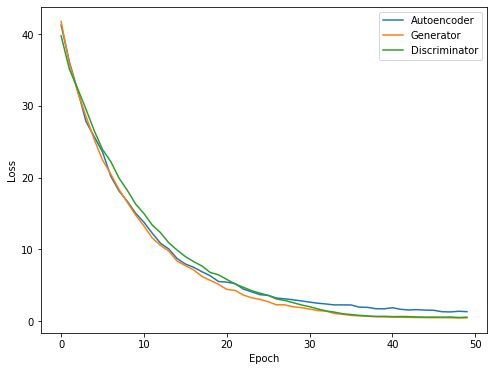

In [12]:
# Plot training & validation loss values

plt.figure(figsize=(8, 6))
axes = plt.gca()
plt.plot(rec_loss)
plt.plot(gen_loss)
plt.plot(dis_loss)
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Autoencoder', 'Generator', 'Discriminator'], loc='upper right')
plt.show()

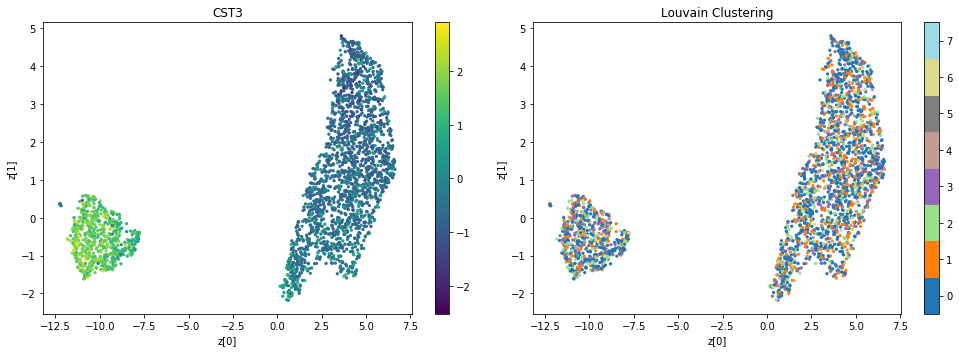

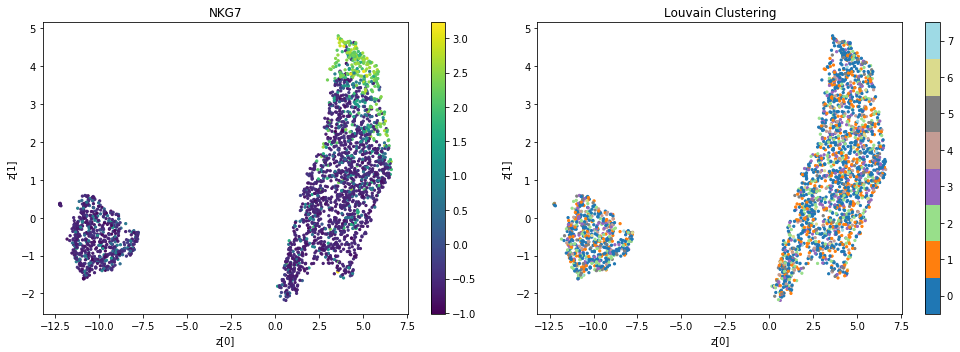

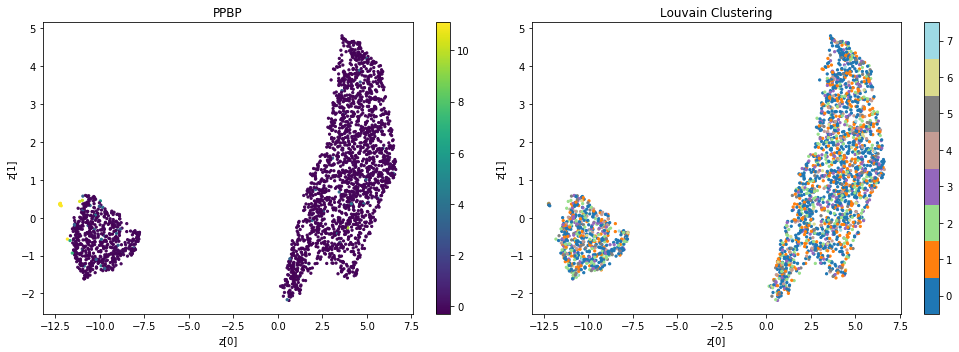

In [13]:
gene_list = ['CST3', 'NKG7', 'PPBP']
model.plot_umap(gene_selected=gene_list, louvain=True)

## Incorporating Label Information in the Adversarial Regularization

### Build the model

In [4]:
# Network parameters

layers_enc_dim = [100,50,50]
layers_dec_dim = [50,50,100]
layers_dis_dim = [50,50,100]
batch_size = 35
latent_dim = 50
epochs = 50

In [5]:
model = AAE2(latent_dim=latent_dim,
             layers_enc_dim=layers_enc_dim, 
             layers_dec_dim=layers_dec_dim, 
             layers_dis_dim=layers_dis_dim,
             batch_size=batch_size,
             epochs=epochs)

In [6]:
# Import dataset

data_path = '../data/proc/pbmc3k.h5ad'

model.load_data(data_path)

Dataset imported.


In [7]:
# Rescale gene expression data

model.rescale_data()

Gene expression data rescaled.


In [8]:
# Show network hyper-parameters

print("List of Network parameters")
model.get_parameters()

List of Network parameters


Value                               Description
latent_dim                      50               dimension of latent space Z
layer_1_enc_dim                100        dimension of encoder dense layer 1
layer_2_enc_dim                 50        dimension of encoder dense layer 2
layer_3_enc_dim                 50        dimension of encoder dense layer 3
layer_1_dec_dim                 50        dimension of decoder dense layer 1
layer_2_dec_dim                 50        dimension of decoder dense layer 2
layer_3_dec_dim                100        dimension of decoder dense layer 3
layer_1_dis_dim                 50  dimension of discriminator dense layer 1
layer_2_dis_dim                 50  dimension of discriminator dense layer 2
layer_3_dis_dim                100  dimension of discriminator dense layer 3
alpha                          0.1       alpha coeff. in activation function
do_rate                        0.1                              dropout rate
kernel_initializer  glorot_uniform    kernel initializer of all dense layers
bias_initializer             zeros      bias initializer of all dense layers
l2_weight                     0.01        weight of l2 kernel regularization
l2_weight                     0.01      weight of l1 activity regularization
batch_size                      35                                batch size
epochs                          50                          number of epochs
lr_dis                      0.0001               learning rate discriminator
lr_gen                      0.0001                   learning rate generator
lr_ae                       0.0002                 learning rate autoencoder
dr_dis                       1e-06                  decay rate discriminator
dr_gen                       1e-06                      decay rate generator
dr_ae                        1e-06                    decay rate autoencoder

In [9]:
# Build the full model

model.build_model()

In [10]:
# Model summary

model.get_summary()


Encoder Network
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
X (InputLayer)                  (None, 1838)         0                                            
__________________________________________________________________________________________________
D_O (Dropout)                   (None, 1838)         0           X[0][0]                          
__________________________________________________________________________________________________
H_1 (Dense)                     (None, 100)          183800      D_O[0][0]                        
__________________________________________________________________________________________________
BN_1 (BatchNormalization)       (None, 100)          400         H_1[0][0]                        
____________________________________________________________________________________________

In [11]:
# Export model graphs

os.makedirs('../graphs/AAE2/PBMC3k', exist_ok=True)
model.export_graph('../graphs/AAE2/PBMC3k')

Model graphs saved.



### Visualize graphs


ENCODER


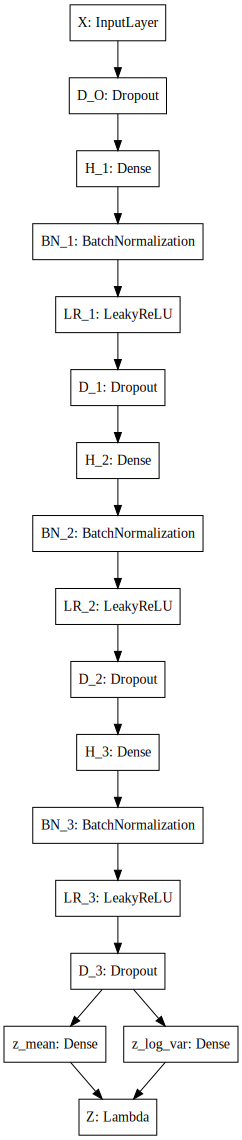

In [11]:
print("\nENCODER")
print("=======")
SVG(model_to_dot(model.encoder).create(prog='dot', format='svg'))


DECODER


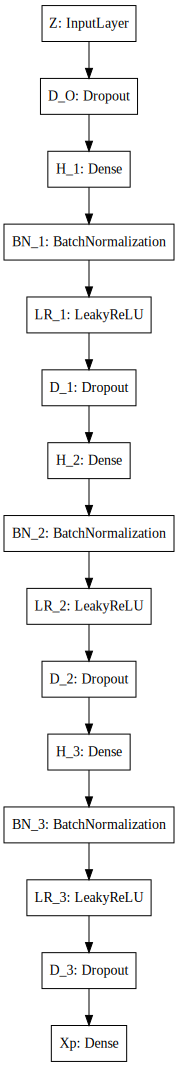

In [12]:
print("\nDECODER")
print("=======")
SVG(model_to_dot(model.decoder).create(prog='dot', format='svg'))


AUTOENCODER


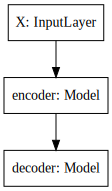

In [13]:
print("\nAUTOENCODER")
print("===========")
SVG(model_to_dot(model.autoencoder).create(prog='dot', format='svg'))


GENERATOR


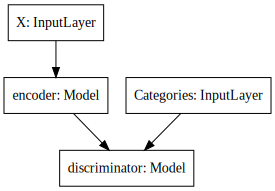

In [14]:
print("\nGENERATOR")
print("=========")
SVG(model_to_dot(model.generator).create(prog='dot', format='svg'))


DISCRIMINATOR


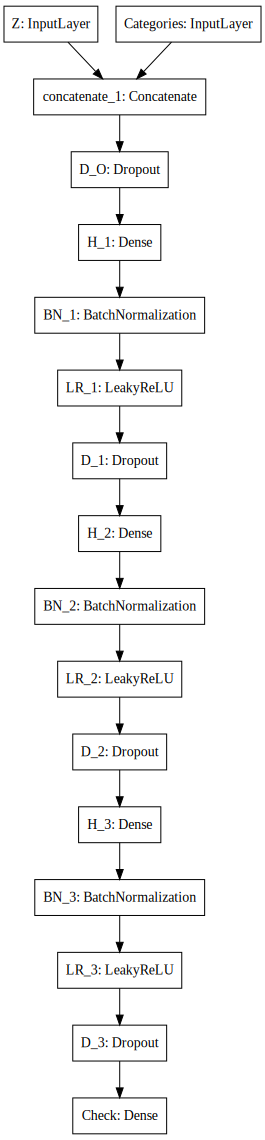

In [15]:
print("\nDISCRIMINATOR")
print("=============")
SVG(model_to_dot(model.discriminator).create(prog='dot', format='svg'))

### Train the model

Epoch 50/50, reconstruction loss: 1.633830, generation loss: 0.489770, discriminator loss: 0.547568


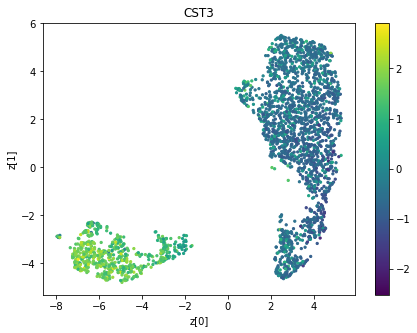

Training completed.


In [11]:
# graph=True to show the data points in the 2-D latent space

gene = 'CST3' # used only for training visualization 

rec_loss, gen_loss, dis_loss = model.train(graph=True, gene=gene)

In [18]:
# save models in h5 format
os.makedirs('../models/AAE2/PBMC3k', exist_ok=True)
model.export_model('../models/AAE2/PBMC3k')

All networks exported in h5 format.


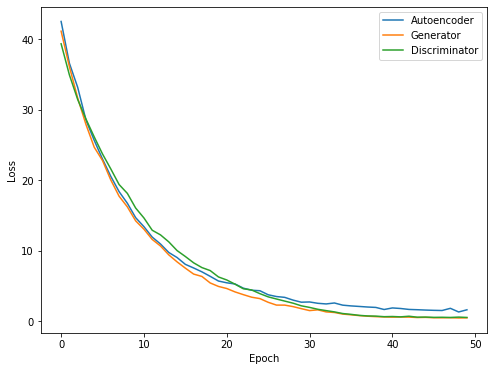

In [12]:
# Plot training & validation loss values

plt.figure(figsize=(8, 6))
axes = plt.gca()
plt.plot(rec_loss)
plt.plot(gen_loss)
plt.plot(dis_loss)
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Autoencoder', 'Generator', 'Discriminator'], loc='upper right')
plt.show()

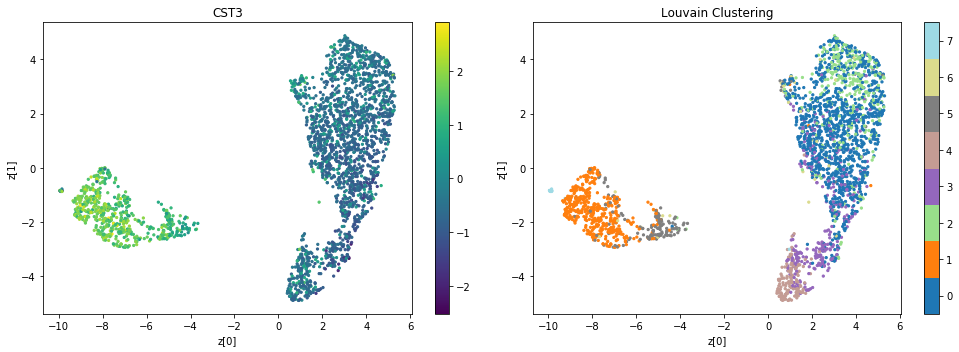

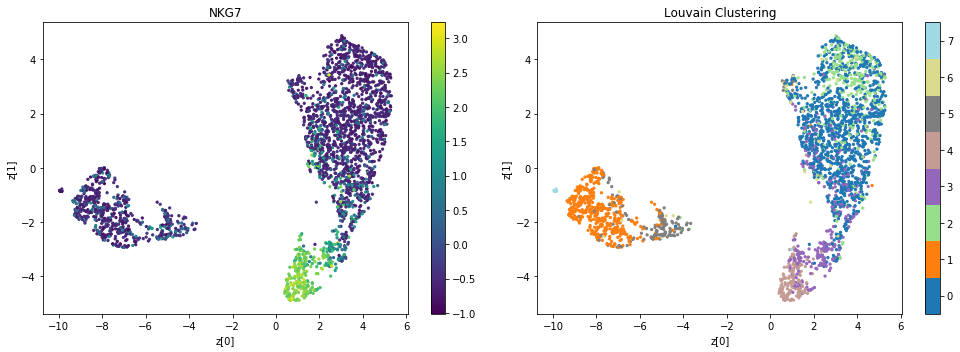

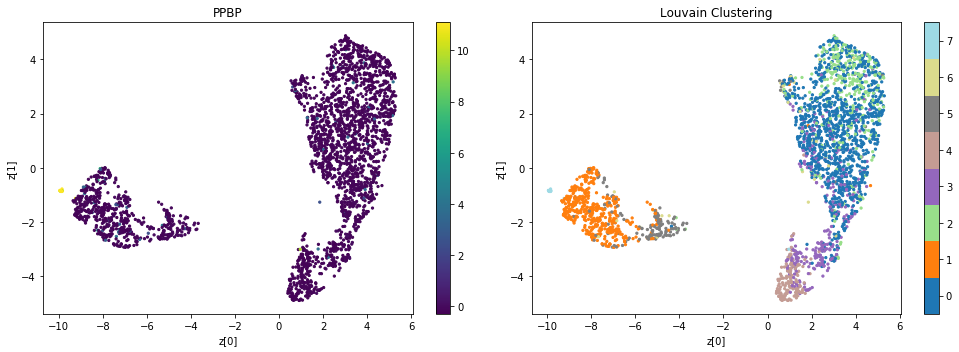

In [13]:
gene_list = ['CST3', 'NKG7', 'PPBP']
model.plot_umap(gene_selected=gene_list, louvain=True)